# Top Model Configurations

**Import Packages**
The following cell will import the required packages, and print the their current version, and indicate how many GPU's are connected to the system.

In [39]:
# Project Dependencies | Double Click to Expand/Collapse
# Author: Luke Collins 
# Date Created: 2021-09-28
# Date Modified: 2021-09-28
# Description: This file contains the code used in the publication "XX" to select the base_model for this study.

import os
import time
import numpy as np
import pandas as pd
import seaborn as sns
import pydot

import matplotlib as mpl
import matplotlib.pyplot as plt

import sklearn as sk
from sklearn.metrics import confusion_matrix, roc_curve, f1_score, auc
from sklearn.metrics import precision_score, recall_score

import tensorflow as tf
from tensorflow import keras
from keras import backend as K
from tensorflow.keras.layers import Input, Dense, Flatten, GlobalAveragePooling2D, Dropout, BatchNormalization, Conv2D, MaxPooling2D, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.applications import Xception, InceptionV3, ResNet50, VGG16, VGG19 
from tensorflow.keras.applications.xception import preprocess_input as xception_preprocess_input
from tensorflow.keras.applications.inception_v3 import preprocess_input as inception_v3_preprocess_input
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet50_preprocess_input
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg16_preprocess_input
from tensorflow.keras.applications.vgg19 import preprocess_input as vgg19_preprocess_input
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import BinaryAccuracy, Precision, Recall, AUC
from tensorflow.keras.regularizers import l1, l2, l1_l2
from tensorflow.keras.utils import plot_model

print("Printing versions of libraries used:")
print("Numpy version:", np.__version__)
print("Pandas version:", pd.__version__)
print("Seaborn:", sns.__version__)
print("Pydot:", pydot.__version__)
print("Matplotlib:", mpl.__version__)
print("Scikit-learn version:", sk.__version__)
print("Tensorflow version:", tf.__version__)
print("Number of GPUs Available: ", len(tf.config.list_physical_devices('GPU')))



Printing versions of libraries used:
Numpy version: 1.23.5
Pandas version: 2.0.1
Seaborn: 0.12.2
Pydot: 1.4.2
Matplotlib: 3.7.1
Scikit-learn version: 1.2.2
Tensorflow version: 2.12.0
Number of GPUs Available:  1


----
## **Notebook Configuration Cell**  
The following cell should always be run directly after the packages are imported, this is where you will configure directories to suit your system if reproducing this experiment at home. Do not proceed if your cells output produces and `false` for any of the directories.

**Warning**   
Before altering path, if you wish the use a different dataset on a specific test, we recommend change the `experiment_train_directory` or `experiment_test_directory` on lines 5-6 of the experiment cell.

In [40]:
# Project Configuration File | Double Click to Expand/Collapse
# Load Directories
#train_directory = "/media/luke/System Storage/Deepfake Dataset/FF++/combine/train" # Please read warning above before altering.
#test_directory = "/media/luke/System Storage/Deepfake Dataset/FF++/combine/test"
train_directory = "/home/luke/Development/deepfake-detection/datasets/train-5" # Please read warning above before altering.
test_directory = "/home/luke/Development/deepfake-detection/datasets/test-10"

experiment_base_directory = "../experiments/top-model-configuration"

# Create directories if they don't exist
os.makedirs(experiment_base_directory, exist_ok=True)

# Check if directories exist
print("Train directory exists:", os.path.isdir(train_directory))
print("Test directory exists:", os.path.isdir(test_directory))
print("Experiment directory exists:", os.path.isdir(experiment_base_directory))

Train directory exists: True
Test directory exists: True
Experiment directory exists: True


----
## **Dataset Creation Utilities**  
The following cell will define the functions required to create the training, validation and test datasets.

In [42]:
# Project Dataset Creation Utilities | Double Click to Expand/Collapse
def create_train_val_datasets(
    preprocessing_model,
    input_dir,
    img_height=299,
    img_width=299,
    batch_size=32,
    augment_data=False
):
    """
    Creates train and validation datasets from images in the input directory.

    Args:
        preprocessing_model (function): The preprocessing function to apply to the images.
        input_dir (str): The path to the input directory containing 'real' and 'fake' subdirectories.
        img_height (int): The height of the input images. Default is 299.
        img_width (int): The width of the input images. Default is 299.
        batch_size (int): The batch size for the data generators. Default is 32.
    Returns:
        tf.data.Dataset, tf.data.Dataset: The train and validation datasets.
    """
    normalDatagen = ImageDataGenerator(
        preprocessing_function=preprocessing_model,
        validation_split=0.2
    )

    augmentDatagen = ImageDataGenerator(
            preprocessing_function=preprocessing_model,
            rotation_range=10,              # Random rotation within +/- 10 degrees
            width_shift_range=0.1,          # Random horizontal shift within +/- 10% of image width
            height_shift_range=0.1,         # Random vertical shift within +/- 10% of image height
            shear_range=0.1,                # Random shearing
            zoom_range=0.1,                 # Random zooming
            horizontal_flip=True,           # Horizontal flipping
            brightness_range=[0.8, 1.2],    # Random brightness adjustment within the given range
            validation_split=0.2
    )


    datagen = augmentDatagen if augment_data else normalDatagen
    train_gen = datagen.flow_from_directory(
        input_dir,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode="binary",
        subset="training",
        shuffle=True
    )

    val_gen = normalDatagen.flow_from_directory(
        input_dir,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode="binary",
        subset="validation",
        shuffle=True
    )

    return train_gen, val_gen

def create_train_dataset(
    preprocessing_model,
    input_dir,
    img_height=299,
    img_width=299,
    batch_size=32,
    augment_data=False
):
    """
    Creates train and validation datasets from images in the input directory.

    Args:
        preprocessing_model (function): The preprocessing function to apply to the images.
        input_dir (str): The path to the input directory containing 'real' and 'fake' subdirectories.
        img_height (int): The height of the input images. Default is 299.
        img_width (int): The width of the input images. Default is 299.
        batch_size (int): The batch size for the data generators. Default is 32.
    Returns:
        tf.data.Dataset, tf.data.Dataset: The train and validation datasets.
    """
    normalDatagen = ImageDataGenerator(
        preprocessing_function=preprocessing_model,
        validation_split=0.2
    )

    augmentDatagen = ImageDataGenerator(
            preprocessing_function=preprocessing_model,
            rotation_range=10,              # Random rotation within +/- 10 degrees
            width_shift_range=0.1,          # Random horizontal shift within +/- 10% of image width
            height_shift_range=0.1,         # Random vertical shift within +/- 10% of image height
            shear_range=0.1,                # Random shearing
            zoom_range=0.1,                 # Random zooming
            horizontal_flip=True,           # Horizontal flipping
            brightness_range=[0.8, 1.2],    # Random brightness adjustment within the given range
            validation_split=0.2
    )


    datagen = augmentDatagen if augment_data else normalDatagen
    return datagen.flow_from_directory(
        input_dir,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode="binary",
        subset="training",
        shuffle=True,
    )

def create_test_dataset(
    preprocessing_model,
    input_dir,
    img_height=299,
    img_width=299,
    batch_size=32,
):
    """
    Creates a test dataset from images in the input directory.

    Args:
        preprocessing_model (function): The preprocessing function to apply to the images.
        input_dir (str): The path to the input directory containing 'real' and 'fake' subdirectories..
        img_height (int): The height of the input images. Default is 299.
        img_width (int): The width of the input images. Default is 299.
        batch_size (int): The batch size for the data generators. Default is 32.
        save_dataset (bool): Whether to save the dataset as a TFRecord file. Default is True.
    Returns:
        tf.data.Dataset: The test dataset.
    """
    datagen = ImageDataGenerator(
        preprocessing_function=preprocessing_model
    )

    return datagen.flow_from_directory(
        input_dir,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode="binary",
        shuffle=True,
    )

----
## **Plotting Utilities**  
The following cell will define the functions required to plot model accuracy on training and validation metrics.

In [12]:
# Project Plot/Graphic Creation Utilities | Double Click to Expand/Collapse
def create_accuracy_plots(folder_path):
    """
    Creates accuracy plots for each epoch report in the specified folder.

    Args:
        folder_path (str): Path to the folder containing the epoch reports.

    Returns:
        None
    """
    # Get a list of all CSV files in the folder
    epoch_reports = [file for file in os.listdir(folder_path) if file.endswith('epochs_report.csv')]

    # Create the accuracy_plots directory if it doesn't exist
    accuracy_plots_path = os.path.join(folder_path, 'accuracy_plots')
    os.makedirs(accuracy_plots_path, exist_ok=True)

    # Cycle through the epoch reports and create plots
    for report in epoch_reports:
        # Read the epoch history CSV file
        report_path = os.path.join(folder_path, report)
        df = pd.read_csv(report_path)

        # Get the number of epochs
        epochs = range(1, len(df) + 1)

        # Extract the relevant columns
        train_accuracy = df['binary_accuracy']
        train_loss = df['loss']
        val_accuracy = df['val_binary_accuracy']
        val_loss = df['val_loss']

        # Create the plot
        plt.figure(figsize=(8, 6))
        plt.plot(epochs, train_accuracy, label='Training Accuracy')
        plt.plot(epochs, train_loss, label='Training Loss')
        plt.plot(epochs, val_accuracy, label='Validation Accuracy')
        plt.plot(epochs, val_loss, label='Validation Loss')

        # Set plot title and labels
        plot_name = report.split('_')[0] + '_accuracy_plot.png'
        plt.title(f'Accuracy History - {plot_name.split("_")[0]} Model')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')

        # Set plot legend
        plt.legend()

        # Save the plot
        plot_path = os.path.join(accuracy_plots_path, plot_name)
        plt.savefig(plot_path)

        # Display the plot (optional)
        plt.show()

def create_all_metrics_plots(folder_path):
    """
    Creates plots for various metrics (accuracy, precision, recall) for each epoch report in the specified folder.

    Args:
        folder_path (str): Path to the folder containing the epoch reports.

    Returns:
        None
    """
    # Get a list of all CSV files in the folder
    epoch_reports = [file for file in os.listdir(folder_path) if file.endswith('epochs_report.csv')]

    # Create the accuracy_plots directory if it doesn't exist
    accuracy_plots_path = os.path.join(folder_path, 'accuracy_plots')
    os.makedirs(accuracy_plots_path, exist_ok=True)

    # Cycle through the epoch reports and create plots
    for report in epoch_reports:
        # Read the epoch history CSV file
        report_path = os.path.join(folder_path, report)
        df = pd.read_csv(report_path)

        # Get the number of epochs
        epochs = range(1, len(df) + 1)

        # Extract the relevant columns
        train_accuracy = df['binary_accuracy']
        train_precision = df['precision']
        train_recall = df['recall']
        val_accuracy = df['val_binary_accuracy']
        val_precision = df['val_precision']
        val_recall = df['val_recall']

        # Create the plot
        plt.figure(figsize=(8, 6))
        plt.plot(epochs, train_accuracy, label='Train Accuracy')
        plt.plot(epochs, train_precision, label='Train Precision')
        plt.plot(epochs, train_recall, label='Train Recall')
        plt.plot(epochs, val_accuracy, label='Validation Accuracy')
        plt.plot(epochs, val_precision, label='Validation Precision')
        plt.plot(epochs, val_recall, label='Validation Recall')

        # Set plot title and labels
        plot_name = report.split('_')[0] + '_metrics_plot.png'
        plt.title(f'Metrics History - {plot_name}')
        plt.xlabel('Epochs')
        plt.ylabel('Metrics')

        # Set plot legend
        plt.legend()

        # Save the plot
        plot_path = os.path.join(accuracy_plots_path, plot_name)
        plt.savefig(plot_path)

        # Display the plot (optional)
        plt.show()

def create_model_image(model, output_dir, name = 'model', extension = 'png'):
    """
    Creates an image of a TensorFlow model's structure and saves it to the specified directory.

    Args:
        model: The TensorFlow model to visualize.
        output_dir: The directory where the model image should be saved.
        name: The name of the model image file. Default is 'model'.
        extension: The file extension for the model image file. Default is 'png'.

    Returns:
        None
    """
    if extension not in ['png', 'svg', 'pdf', 'jpg']:
        throw(f'Invalid file extension: {extension}')
        
    # Ensure the output directory exists
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Construct the full path for the output file
    output_file = os.path.join(output_dir, f'{name}.{extension}')

    # Generate and save the model image
    plot_model(model, to_file=output_file, show_shapes=True, show_layer_names=True)

---
# Experiments
---
## Experiment #TMC-0001 | Initial Model Fine-Tuning
**Experiment ID:** #TMC-0001  
**Experiment Description:**   
  
**Experiment Outcome:**  
**Next Test:** 

Found 193164 images belonging to 2 classes.
Found 48290 images belonging to 2 classes.
Found 42786 images belonging to 2 classes.


2023-05-27 19:04:39.828670: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-05-27 19:04:39.829004: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-05-27 19:04:39.829271: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Epoch 1/50


2023-05-27 19:04:41.551567: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-05-27 19:04:44.848508: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2023-05-27 19:04:47.023424: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-05-27 19:04:47.028489: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x55ff8f028c00 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-05-27 19:04:47.028506: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA GeForce RTX 3070, Compute Capability 8.6
2023-05-27 19:04:47.03208

6036/6036 [==============================] - ETA: 0s - loss: 0.7138 - binary_accuracy: 0.8455 - precision: 0.8369 - recall: 0.8466 - auc: 0.9302

2023-05-27 19:39:21.116440: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


6036/6036 [==============================] - 2219s 366ms/step - loss: 0.7138 - binary_accuracy: 0.8455 - precision: 0.8369 - recall: 0.8466 - auc: 0.9302 - val_loss: 0.7606 - val_binary_accuracy: 0.8097 - val_precision: 0.8694 - val_recall: 0.7155 - val_auc: 0.8957 - lr: 1.0000e-04
Epoch 2/50
6036/6036 [==============================] - 2147s 356ms/step - loss: 0.3119 - binary_accuracy: 0.9443 - precision: 0.9409 - recall: 0.9446 - auc: 0.9867 - val_loss: 0.5137 - val_binary_accuracy: 0.8346 - val_precision: 0.8263 - val_recall: 0.8345 - val_auc: 0.9122 - lr: 1.0000e-04
Epoch 3/50
6036/6036 [==============================] - 2127s 352ms/step - loss: 0.1579 - binary_accuracy: 0.9633 - precision: 0.9611 - recall: 0.9634 - auc: 0.9932 - val_loss: 0.5682 - val_binary_accuracy: 0.8284 - val_precision: 0.8488 - val_recall: 0.7867 - val_auc: 0.8974 - lr: 1.0000e-04
Epoch 4/50
6036/6036 [==============================] - 2118s 351ms/step - loss: 0.1106 - binary_accuracy: 0.9718 - precision: 0.

2023-05-27 22:03:25.666160: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


1337/1337 [==============================] - 127s 95ms/step - loss: 0.4071 - binary_accuracy: 0.8864 - precision: 0.9005 - recall: 0.8613 - auc: 0.9480


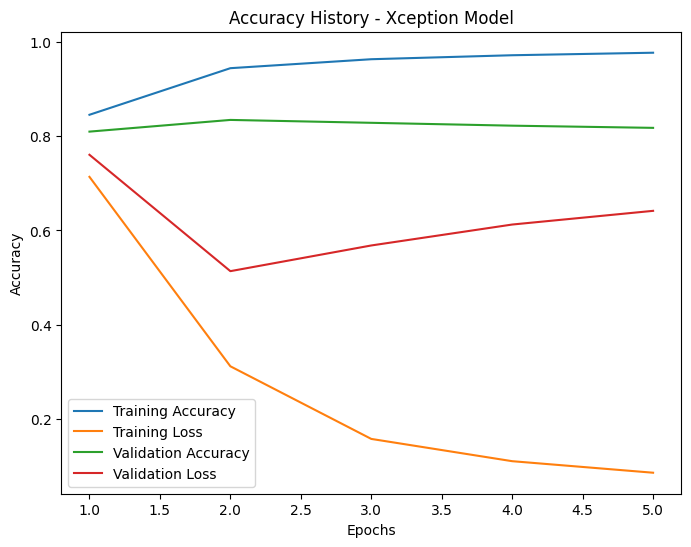

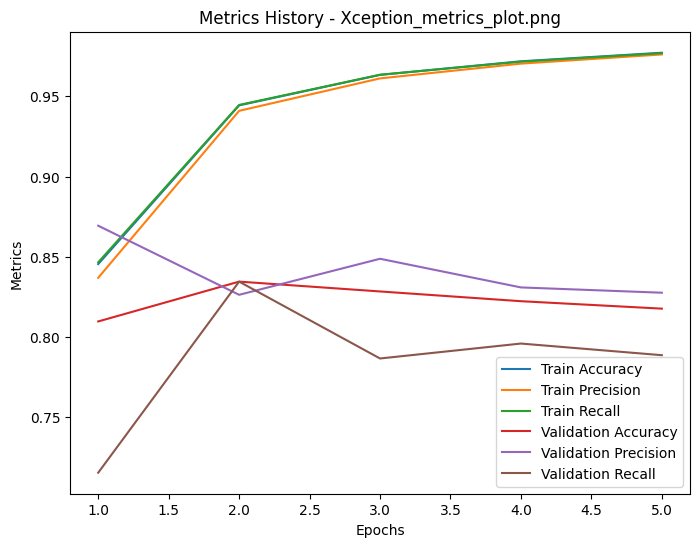

In [6]:
# Experiment ID:TMC-0001 - Xception 
experimentId = "TMC-0001"

# Load Directories (Leave alone unless specifying a different dataset)
experiment_train_directory = train_directory
experiment_test_directory = test_directory
experiment_directory = f"{experiment_base_directory}/{experimentId}"
experiment_results_directory = f"{experiment_directory}/results"
experiment_models_directory = f"{experiment_directory}/models"

# Create directories if they don't exist
os.makedirs(name=experiment_directory, exist_ok=True)
os.makedirs(name=experiment_models_directory, exist_ok=True)
os.makedirs(name=experiment_results_directory, exist_ok=True)

# Declare lists for report generation
accuracy_report = []

# Declare Test Configurations
test_configurations = [
    [Xception, xception_preprocess_input]
]

# Define Early Stopping Callback
# Define callbacks
early_stopping = EarlyStopping(
    monitor='val_loss', 
    mode='min', 
    verbose=1, 
    patience=3
)

lr_reducer = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=3,
    verbose=1,
)

model_checkpoint = ModelCheckpoint(
    filepath=f"{experiment_models_directory}/model.h5",
    monitor="val_loss",
    save_best_only=True,
)


# Loop through all combinations of models and trainable layers
for pretrained_model, preprocessing_function in test_configurations:
    K.clear_session()
    
    # Create a dataset and preprocess images to suit base model
    train_ds, val_ds = create_train_val_datasets(preprocessing_function, experiment_train_directory, batch_size=32, augment_data=True)
    test_ds = create_test_dataset(preprocessing_function, experiment_test_directory, batch_size=32)

    # Create Input Layer
    inputs = Input(shape=(299, 299, 3))

    # Create the base model from the pre-trained model
    base_model = pretrained_model(
        weights="imagenet", 
        include_top=False,
        input_tensor=inputs)

    # Make Base Model Trainable
    base_model.trainable = True
    
    # Freeze the base model (do not train everything but last 23 layers)
    for layer in base_model.layers[:-23]:
        layer.trainable = False
    
    # Add a classification head
    top_model = base_model(inputs, training = True)
    top_model = GlobalAveragePooling2D()(top_model)

    top_model = Dense(512, kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4))(top_model)
    top_model = BatchNormalization()(top_model)
    top_model = Activation('relu')(top_model)
    top_model = Dropout(0.8)(top_model)

    top_model = Dense(256, kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4))(top_model)
    top_model = BatchNormalization()(top_model)
    top_model = Activation('relu')(top_model)
    top_model = Dropout(0.4)(top_model)
    
    predictions = Dense(1, activation='sigmoid')(top_model)
    model = Model(inputs=base_model.input, outputs=predictions)

    # Compile the model
    model.compile(
        optimizer=Adam(1e-4),  
        loss=BinaryCrossentropy(from_logits=False),
        metrics=[BinaryAccuracy(), Precision(), Recall(), AUC()]
    )
    
    # Create Model Image
    create_model_image(model, experiment_models_directory, name = f'{pretrained_model.__name__}_model', extension = 'png')
    
    # Start Timer to measure processing time 
    start_time = time.time()

    # Train the model but first clear history (Required to append results without errors)
    history = model.fit(
        train_ds, 
        steps_per_epoch=train_ds.samples // train_ds.batch_size,
        epochs=50, 
        validation_data=val_ds,
        validation_steps=val_ds.samples // val_ds.batch_size,
        callbacks = [early_stopping, lr_reducer, model_checkpoint]
    )
    
    # End Timer and calculate processing time
    end_time = time.time()
    processing_time = end_time - start_time

    # Evaluate the model
    evaluate = model.evaluate(test_ds, steps = test_ds.samples // test_ds.batch_size, verbose=1)
    
    # Append results to accuracy_test list
    history_key = list(history.history.keys()) # As names of metric names can be dynamic, we need to get the keys of the history object
    accuracy_report.append({
        'Base Model': pretrained_model.__name__,
        'duration': round(processing_time, 3),
        'test_accuracy': round(evaluate[1], 3),
        'test_precision': round(evaluate[2], 3),
        'test_recall': round(evaluate[3], 3),
        'test_loss': round(evaluate[0], 3),
        'train_accuracy': round(history.history[history_key[1]][-1],3),
        'train_precision': round(history.history[history_key[2]][-1],3),
        'train_recall': round(history.history[history_key[3]][-1],3),
        'train_auc' : round(history.history[history_key[4]][-1],3),
        'train_loss': round(history.history[history_key[0]][-1],3),
        'val_accuracy': round(history.history[history_key[6]][-1],3),
        'val_precision': round(history.history[history_key[7]][-1],3),
        'val_recall': round(history.history[history_key[8]][-1],3),
        'val_auc' : round(history.history[history_key[9]][-1],3),
        'val_loss': round(history.history[history_key[5]][-1],3)
    })
    
    epochs_report = pd.DataFrame(history.history)
    epochs_report.to_csv(f"{experiment_results_directory}/{pretrained_model.__name__}_epochs_report.csv", index=False)

# Create DataFrame with accuracy score and export as .csv
accuracy_test_results = pd.DataFrame(accuracy_report)
accuracy_test_results.to_csv(f'{experiment_results_directory}/accuracy_test_results.csv', index=False)

# Generate graphs from epochs_reports.csv and output to results folder.
create_accuracy_plots(f"{experiment_results_directory}")
create_all_metrics_plots(f"{experiment_results_directory}")

Found 193164 images belonging to 2 classes.
Found 48290 images belonging to 2 classes.
Found 42786 images belonging to 2 classes.
Epoch 1/50


2023-05-27 22:05:37.566834: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


3018/3018 [==============================] - ETA: 0s - loss: 0.8193 - binary_accuracy: 0.8048 - precision: 0.7967 - recall: 0.8026 - auc: 0.8952

2023-05-27 22:38:55.832137: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]



Epoch 1: val_binary_accuracy improved from -inf to 0.79294, saving model to ../experiments/top-model-configuration/TMC-0002/models/model.h5
3018/3018 [==============================] - 2127s 702ms/step - loss: 0.8193 - binary_accuracy: 0.8048 - precision: 0.7967 - recall: 0.8026 - auc: 0.8952 - val_loss: 0.9374 - val_binary_accuracy: 0.7929 - val_precision: 0.8410 - val_recall: 0.7071 - val_auc: 0.8779 - lr: 1.0000e-04
Epoch 2/50
3018/3018 [==============================] - ETA: 0s - loss: 0.4563 - binary_accuracy: 0.9437 - precision: 0.9389 - recall: 0.9456 - auc: 0.9860
Epoch 2: val_binary_accuracy improved from 0.79294 to 0.82402, saving model to ../experiments/top-model-configuration/TMC-0002/models/model.h5
3018/3018 [==============================] - 2100s 696ms/step - loss: 0.4563 - binary_accuracy: 0.9437 - precision: 0.9389 - recall: 0.9456 - auc: 0.9860 - val_loss: 0.8583 - val_binary_accuracy: 0.8240 - val_precision: 0.8740 - val_recall: 0.7447 - val_auc: 0.8972 - lr: 1.000

2023-05-28 08:38:07.257310: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


668/668 [==============================] - 122s 182ms/step - loss: 0.5535 - binary_accuracy: 0.8859 - precision: 0.9119 - recall: 0.8471 - auc: 0.9391


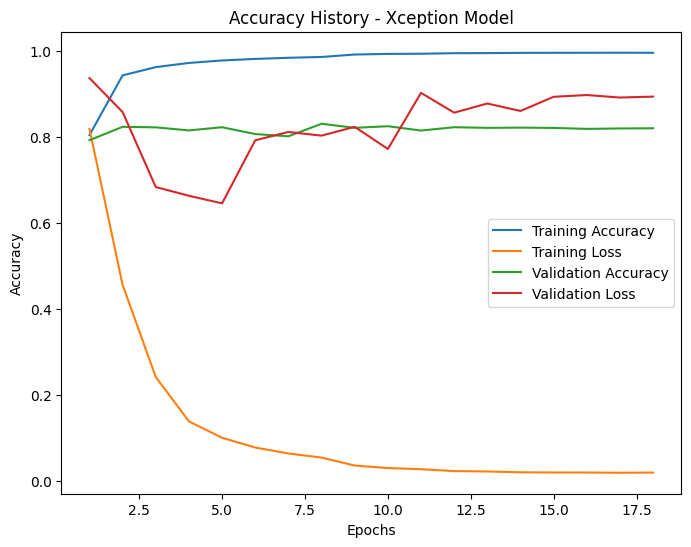

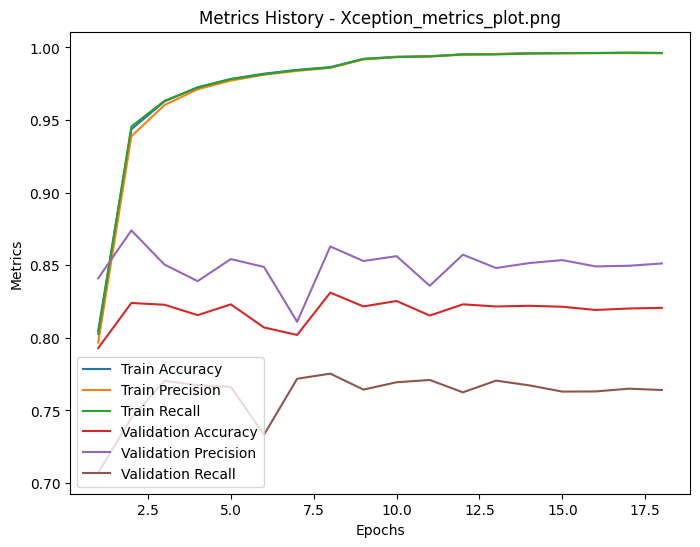

In [7]:
# Experiment ID:TMC-0002 - Xception 
experimentId = "TMC-0002"

# Load Directories (Leave alone unless specifying a different dataset)
experiment_train_directory = train_directory
experiment_test_directory = test_directory
experiment_directory = f"{experiment_base_directory}/{experimentId}"
experiment_results_directory = f"{experiment_directory}/results"
experiment_models_directory = f"{experiment_directory}/models"

# Create directories if they don't exist
os.makedirs(name=experiment_directory, exist_ok=True)
os.makedirs(name=experiment_models_directory, exist_ok=True)
os.makedirs(name=experiment_results_directory, exist_ok=True)

# Declare lists for report generation
accuracy_report = []

# Declare Test Configurations
test_configurations = [
    [Xception, xception_preprocess_input]
]

# Define Early Stopping Callback
# Define callbacks
early_stopping = EarlyStopping(
    monitor='val_binary_accuracy', 
    mode='max', 
    verbose=1, 
    patience=10
)

lr_reducer = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.25,
    patience=3,
    verbose=1,
)

model_checkpoint = ModelCheckpoint(
    filepath=f"{experiment_models_directory}/model.h5",
    monitor="val_binary_accuracy",
    save_best_only=True,
    verbose=1, 
)


# Loop through all combinations of models and trainable layers
for pretrained_model, preprocessing_function in test_configurations:
    K.clear_session()
    
    # Create a dataset and preprocess images to suit base model
    train_ds, val_ds = create_train_val_datasets(preprocessing_function, experiment_train_directory, batch_size=64, augment_data=True)
    test_ds = create_test_dataset(preprocessing_function, experiment_test_directory, batch_size=64)

    # Create Input Layer
    inputs = Input(shape=(299, 299, 3))

    # Create the base model from the pre-trained model
    base_model = pretrained_model(
        weights="imagenet", 
        include_top=False,
        input_tensor=inputs)

    # Make Base Model Trainable
    base_model.trainable = True
    
    # Freeze the base model (do not train everything but last 23 layers)
    for layer in base_model.layers[:-23]:
        layer.trainable = False
    
    # Add a classification head
    top_model = base_model(inputs, training = True)
    top_model = GlobalAveragePooling2D()(top_model)

    top_model = Dense(512, kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4))(top_model)
    top_model = BatchNormalization()(top_model)
    top_model = Activation('relu')(top_model)
    top_model = Dropout(0.6)(top_model)
    
    top_model = Dense(512, kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4))(top_model)
    top_model = BatchNormalization()(top_model)
    top_model = Activation('relu')(top_model)
    top_model = Dropout(0.6)(top_model)

    top_model = Dense(256, kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4))(top_model)
    top_model = BatchNormalization()(top_model)
    top_model = Activation('relu')(top_model)
    top_model = Dropout(0.4)(top_model)
    
    top_model = Dense(256, kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4))(top_model)
    top_model = BatchNormalization()(top_model)
    top_model = Activation('relu')(top_model)
    top_model = Dropout(0.4)(top_model)
    
    predictions = Dense(1, activation='sigmoid')(top_model)
    model = Model(inputs=base_model.input, outputs=predictions)

    # Compile the model
    model.compile(
        optimizer=Adam(1e-4),  
        loss=BinaryCrossentropy(from_logits=False),
        metrics=[BinaryAccuracy(), Precision(), Recall(), AUC()]
    )
    
    # Create Model Image
    create_model_image(model, experiment_models_directory, name = f'{pretrained_model.__name__}_model', extension = 'png')
    
    # Start Timer to measure processing time 
    start_time = time.time()

    # Train the model but first clear history (Required to append results without errors)
    history = model.fit(
        train_ds, 
        steps_per_epoch=train_ds.samples // train_ds.batch_size,
        epochs=50, 
        validation_data=val_ds,
        validation_steps=val_ds.samples // val_ds.batch_size,
        callbacks = [early_stopping, lr_reducer, model_checkpoint]
    )
    
    # End Timer and calculate processing time
    end_time = time.time()
    processing_time = end_time - start_time

    # Evaluate the model
    evaluate = model.evaluate(test_ds, steps = test_ds.samples // test_ds.batch_size, verbose=1)
    
    # Append results to accuracy_test list
    history_key = list(history.history.keys()) # As names of metric names can be dynamic, we need to get the keys of the history object
    accuracy_report.append({
        'Base Model': pretrained_model.__name__,
        'duration': round(processing_time, 3),
        'test_accuracy': round(evaluate[1], 3),
        'test_precision': round(evaluate[2], 3),
        'test_recall': round(evaluate[3], 3),
        'test_loss': round(evaluate[0], 3),
        'train_accuracy': round(history.history[history_key[1]][-1],3),
        'train_precision': round(history.history[history_key[2]][-1],3),
        'train_recall': round(history.history[history_key[3]][-1],3),
        'train_auc' : round(history.history[history_key[4]][-1],3),
        'train_loss': round(history.history[history_key[0]][-1],3),
        'val_accuracy': round(history.history[history_key[6]][-1],3),
        'val_precision': round(history.history[history_key[7]][-1],3),
        'val_recall': round(history.history[history_key[8]][-1],3),
        'val_auc' : round(history.history[history_key[9]][-1],3),
        'val_loss': round(history.history[history_key[5]][-1],3)
    })
    
    epochs_report = pd.DataFrame(history.history)
    epochs_report.to_csv(f"{experiment_results_directory}/{pretrained_model.__name__}_epochs_report.csv", index=False)

# Create DataFrame with accuracy score and export as .csv
accuracy_test_results = pd.DataFrame(accuracy_report)
accuracy_test_results.to_csv(f'{experiment_results_directory}/accuracy_test_results.csv', index=False)

# Generate graphs from epochs_reports.csv and output to results folder.
create_accuracy_plots(f"{experiment_results_directory}")
create_all_metrics_plots(f"{experiment_results_directory}")

In [15]:
train_ds, val_ds = create_train_val_datasetsOld(train_directory, batch_size=32, augment_training_data=True)
test_ds = create_test_datasetOld(test_directory, batch_size=32)


# Define callbacks
early_stopping = EarlyStopping(
    monitor='val_loss', 
    mode='min', 
    verbose=1, 
    patience=4 # Increase patience
)

model_checkpoint = ModelCheckpoint(
    'models/002/best_model.h5', 
    monitor='val_loss', 
    mode='min', 
    verbose=1, 
    save_best_only=True
)

lr_reducer = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.2,
    patience=3,
    verbose=1,
)

# Train Model
# Define top_model which I will connect with base_model

top_model = base_model.output
top_model = GlobalAveragePooling2D()(top_model)
top_model = Dense(4096, kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4))(top_model)
top_model = Dropout(0.7)(top_model)
top_model = BatchNormalization()(top_model)
top_model = Activation('relu')(top_model)
top_model = Dense(2048, kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4))(top_model)
top_model = BatchNormalization()(top_model)
top_model = Activation('relu')(top_model)
top_model = Dropout(0.5)(top_model)
top_model = Dense(1024, kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4))(top_model)
top_model = BatchNormalization()(top_model)
top_model = Activation('relu')(top_model)
top_model = Dropout(0.2)(top_model)
top_model = Dense(1, activation='sigmoid')(top_model)

# Group the base_model and new fully-connected layers into a Model object
model = Model(inputs = base_model.input, outputs = top_model)

model.compile(
    optimizer=Adam(1e-4),  # Decreased initial learning rate
    loss=BinaryCrossentropy(from_logits=False),
    metrics=[BinaryAccuracy()],
)

history = model.fit(
    train_ds, 
    steps_per_epoch = train_ds.samples // train_ds.batch_size,
    epochs=10,
    validation_data=val_ds,
    validation_steps=val_ds.samples // val_ds.batch_size,
    callbacks = [early_stopping, lr_reducer, model_checkpoint]
)


Found 9660 images belonging to 2 classes.
Found 2414 images belonging to 2 classes.
Found 4279 images belonging to 2 classes.
Epoch 1/10


2023-05-27 15:13:41.776179: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


301/301 [==============================] - ETA: 0s - loss: 3.6044 - binary_accuracy: 0.9414

2023-05-27 15:15:23.726034: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]



Epoch 1: val_loss improved from inf to 3.79382, saving model to models/002/best_model.h5
301/301 [==============================] - 109s 347ms/step - loss: 3.6044 - binary_accuracy: 0.9414 - val_loss: 3.7938 - val_binary_accuracy: 0.7508 - lr: 1.0000e-04
Epoch 2/10
301/301 [==============================] - ETA: 0s - loss: 3.1769 - binary_accuracy: 0.9484
Epoch 2: val_loss improved from 3.79382 to 3.37329, saving model to models/002/best_model.h5
301/301 [==============================] - 105s 348ms/step - loss: 3.1769 - binary_accuracy: 0.9484 - val_loss: 3.3733 - val_binary_accuracy: 0.7971 - lr: 1.0000e-04
Epoch 3/10
301/301 [==============================] - ETA: 0s - loss: 2.8367 - binary_accuracy: 0.9560
Epoch 3: val_loss improved from 3.37329 to 3.16264, saving model to models/002/best_model.h5
301/301 [==============================] - 107s 356ms/step - loss: 2.8367 - binary_accuracy: 0.9560 - val_loss: 3.1626 - val_binary_accuracy: 0.7496 - lr: 1.0000e-04
Epoch 4/10
301/301 [

KeyboardInterrupt: 

In [8]:
train_ds, val_ds = create_train_val_datasetsOld(train_directory, batch_size=32, augment_training_data=True)
test_ds = create_test_datasetOld(test_directory, batch_size=32)


# Define callbacks
early_stopping = EarlyStopping(
    monitor='val_loss', 
    mode='min', 
    verbose=1, 
    patience=10  # Increase patience
)

model_checkpoint = ModelCheckpoint(
    'models/002/best_model.h5', 
    monitor='val_loss', 
    mode='min', 
    verbose=1, 
    save_best_only=True
)

lr_reducer = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=3,
    verbose=1,
)

# Train Model
# Define top_model which I will connect with base_model

top_model = base_model.output
top_model = GlobalAveragePooling2D()(top_model)
top_model = Dense(3070, activation='relu', kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4))(top_model) # Uppded Neurons to 3070 for 2048
top_model = Dropout(0.7)(top_model)  # Increased dropout rate
top_model = Dense(2048, activation='relu', kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4))(top_model)  # Changed Neruons to 2048 for 1024
top_model = Dropout(0.5)(top_model)
top_model = Dense(1024, activation='relu', kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4))(top_model)  # Added bottom two layers
top_model = Dropout(0.2)(top_model)
top_model = Dense(1, activation = 'sigmoid')(top_model)

# Group the base_model and new fully-connected layers into a Model object
model = Model(inputs = base_model.input, outputs = top_model)

model.compile(
    optimizer=Adam(1e-4),  # Decreased initial learning rate
    loss=BinaryCrossentropy(from_logits=False),
    metrics=[BinaryAccuracy()],
)

history = model.fit(
    train_ds, 
    steps_per_epoch = train_ds.samples // train_ds.batch_size,
    epochs=100,  # Increased number of epochs
    validation_data=val_ds,
    validation_steps=val_ds.samples // val_ds.batch_size,
    callbacks = [early_stopping, lr_reducer, model_checkpoint]
)


NameError: name 'create_train_val_datasetsOld' is not defined

In [8]:
train_ds, val_ds = create_train_val_datasets(train_directory, batch_size=32, augment_training_data=True)
test_ds = create_test_dataset(test_directory, batch_size=32)


# Define callbacks
early_stopping = EarlyStopping(
    monitor='val_loss', 
    mode='min', 
    verbose=1, 
    patience=4 # Increase patience
)

model_checkpoint = ModelCheckpoint(
    'models/002/best_model.h5', 
    monitor='val_loss', 
    mode='min', 
    verbose=1, 
    save_best_only=True
)

lr_reducer = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.2,
    patience=3,
    verbose=1,
)

# Train Model
# Define top_model which I will connect with base_model

top_model = base_model.output
top_model = GlobalAveragePooling2D()(top_model)
top_model = Dense(512, kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4))(top_model)
top_model = BatchNormalization()(top_model)
top_model = Activation('relu')(top_model)
top_model = Dropout(0.7)(top_model)
top_model = Dense(512, kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4))(top_model)
top_model = BatchNormalization()(top_model)
top_model = Activation('relu')(top_model)
top_model = Dropout(0.6)(top_model)
top_model = Dense(512, kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4))(top_model)
top_model = BatchNormalization()(top_model)
top_model = Activation('relu')(top_model)
top_model = Dropout(0.5)(top_model)
top_model = Dense(1, activation='sigmoid')(top_model)

# Group the base_model and new fully-connected layers into a Model object
model = Model(inputs = base_model.input, outputs = top_model)

model.compile(
    optimizer=Adam(0.001),  # Decreased initial learning rate
    loss=BinaryCrossentropy(from_logits=False),
    metrics=[BinaryAccuracy()],
)

history = model.fit(
    train_ds, 
    steps_per_epoch = train_ds.samples // train_ds.batch_size,
    epochs=10,
    validation_data=val_ds,
    validation_steps=val_ds.samples // val_ds.batch_size,
    callbacks = [early_stopping, lr_reducer, model_checkpoint]
)


NameError: name 'create_train_val_datasetsOld' is not defined

In [ ]:
evaluate = model.evaluate
print(evaluate)

  1/134 [..............................] - ETA: 22s - loss: 0.4256 - binary_accuracy: 0.9062

2023-05-27 15:54:56.290633: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


134/134 [==============================] - 11s 83ms/step - loss: 0.4495 - binary_accuracy: 0.8871
[0.4494987428188324, 0.887123167514801]


In [ ]:
train_ds, val_ds = create_train_val_datasetsOld(train_directory, batch_size=32, augment_training_data=True)
test_ds = create_test_datasetOld(test_directory, batch_size=32)


# Define callbacks
early_stopping = EarlyStopping(
    monitor='val_loss', 
    mode='min', 
    verbose=1, 
    patience=4 # Increase patience
)

model_checkpoint = ModelCheckpoint(
    'models/003/best_model.h5', 
    monitor='val_loss', 
    mode='min', 
    verbose=1, 
    save_best_only=True
)

lr_reducer = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.2,
    patience=3,
    verbose=1,
)

# Train Model
# Define top_model which I will connect with base_model

top_model = base_model.output
top_model = GlobalAveragePooling2D()(top_model)
top_model = Dense(256, kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4), activation='relu')(top_model)
top_model = BatchNormalization()(top_model)
top_model = Dropout(0.7)(top_model)
top_model = Dense(256, kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4), activation='relu')(top_model)
top_model = BatchNormalization()(top_model)
top_model = Dropout(0.7)(top_model)
top_model = Dense(256, kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4), activation='relu')(top_model)
top_model = BatchNormalization()(top_model)
top_model = Dropout(0.7)(top_model)
top_model = Dense(256, kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4), activation='relu')(top_model)
top_model = BatchNormalization()(top_model)
top_model = Dropout(0.7)(top_model)
top_model = Dense(1, activation='sigmoid')(top_model)

# Group the base_model and new fully-connected layers into a Model object
model = Model(inputs = base_model.input, outputs = top_model)

model.compile(
    optimizer=Adam(0.001),  # Decreased initial learning rate
    loss=BinaryCrossentropy(from_logits=False),
    metrics=[BinaryAccuracy()],
)

history = model.fit(
    train_ds, 
    steps_per_epoch = train_ds.samples // train_ds.batch_size,
    epochs=10,
    validation_data=val_ds,
    validation_steps=val_ds.samples // val_ds.batch_size,
    callbacks = [early_stopping, lr_reducer, model_checkpoint]
)


Found 9660 images belonging to 2 classes.
Found 2414 images belonging to 2 classes.
Found 4279 images belonging to 2 classes.
Epoch 1/10


2023-05-27 15:55:53.776296: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


301/301 [==============================] - ETA: 0s - loss: 0.5459 - binary_accuracy: 0.9061

2023-05-27 15:57:37.034402: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]



Epoch 1: val_loss improved from inf to 0.85281, saving model to models/002/best_model.h5
301/301 [==============================] - 110s 349ms/step - loss: 0.5459 - binary_accuracy: 0.9061 - val_loss: 0.8528 - val_binary_accuracy: 0.8112 - lr: 0.0010
Epoch 2/10
301/301 [==============================] - ETA: 0s - loss: 0.4536 - binary_accuracy: 0.9310
Epoch 2: val_loss did not improve from 0.85281
301/301 [==============================] - 104s 346ms/step - loss: 0.4536 - binary_accuracy: 0.9310 - val_loss: 1.1983 - val_binary_accuracy: 0.6792 - lr: 0.0010
Epoch 3/10
301/301 [==============================] - ETA: 0s - loss: 0.3997 - binary_accuracy: 0.9344
Epoch 3: val_loss did not improve from 0.85281
301/301 [==============================] - 103s 342ms/step - loss: 0.3997 - binary_accuracy: 0.9344 - val_loss: 0.8602 - val_binary_accuracy: 0.7817 - lr: 0.0010
Epoch 4/10
301/301 [==============================] - ETA: 0s - loss: 0.3689 - binary_accuracy: 0.9363
Epoch 4: val_loss imp

In [ ]:
evaluate = model.evaluate(test_ds)
print(evaluate)

2023-05-27 16:14:16.863707: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


134/134 [==============================] - 11s 80ms/step - loss: 1.1213 - binary_accuracy: 0.8455
[1.121268630027771, 0.8455246686935425]


In [ ]:
train_ds, val_ds = create_train_val_datasetsOld(train_directory, batch_size=32, augment_training_data=True)
test_ds = create_test_datasetOld(test_directory, batch_size=32)


# Define callbacks
early_stopping = EarlyStopping(
    monitor='val_loss', 
    mode='min', 
    verbose=1, 
    patience=4 # Increase patience
)

model_checkpoint = ModelCheckpoint(
    'models/004/best_model.h5', 
    monitor='val_loss', 
    mode='min', 
    verbose=1, 
    save_best_only=True
)

lr_reducer = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.2,
    patience=3,
    verbose=1,
)

# Train Model
# Define top_model which I will connect with base_model

top_model = base_model.output
top_model = GlobalAveragePooling2D()(top_model)
top_model = Dense(512, kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4), activation='relu')(top_model)
top_model = BatchNormalization()(top_model)
top_model = Dropout(0.7)(top_model)
top_model = Dense(512, kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4), activation='relu')(top_model)
top_model = BatchNormalization()(top_model)
top_model = Dropout(0.7)(top_model)
top_model = Dense(512, kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4), activation='relu')(top_model)
top_model = BatchNormalization()(top_model)
top_model = Dropout(0.7)(top_model)
top_model = Dense(512, kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4), activation='relu')(top_model)
top_model = BatchNormalization()(top_model)
top_model = Dropout(0.7)(top_model)
top_model = Dense(1, activation='sigmoid')(top_model)

# Group the base_model and new fully-connected layers into a Model object
model = Model(inputs = base_model.input, outputs = top_model)

model.compile(
    optimizer=Adam(0.001),  # Decreased initial learning rate
    loss=BinaryCrossentropy(from_logits=False),
    metrics=[BinaryAccuracy()],
)

history = model.fit(
    train_ds, 
    steps_per_epoch = train_ds.samples // train_ds.batch_size,
    epochs=10,
    validation_data=val_ds,
    validation_steps=val_ds.samples // val_ds.batch_size,
    callbacks = [early_stopping, lr_reducer, model_checkpoint]
)


Found 9660 images belonging to 2 classes.
Found 2414 images belonging to 2 classes.
Found 4279 images belonging to 2 classes.
Epoch 1/10


2023-05-27 16:13:42.624666: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


 15/301 [>.............................] - ETA: 1:27 - loss: 1.3775 - binary_accuracy: 0.7271

KeyboardInterrupt: 

In [ ]:
train_ds, val_ds = create_train_val_datasetsOld(train_directory, batch_size=32, augment_training_data=True)
test_ds = create_test_datasetOld(test_directory, batch_size=32)


# Define callbacks
early_stopping = EarlyStopping(
    monitor='val_loss', 
    mode='min', 
    verbose=1, 
    patience=4 # Increase patience
)

model_checkpoint = ModelCheckpoint(
    'models/005/best_model.h5', 
    monitor='val_loss', 
    mode='min', 
    verbose=1, 
    save_best_only=True
)

lr_reducer = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.2,
    patience=3,
    verbose=1,
)

# Train Model
# Define top_model which I will connect with base_model

top_model = base_model.output
top_model = GlobalAveragePooling2D()(top_model)
top_model = Dense(256, kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4), activation='relu')(top_model)
top_model = BatchNormalization()(top_model)
top_model = Dropout(0.7)(top_model)
top_model = Dense(256, kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4), activation='relu')(top_model)
top_model = BatchNormalization()(top_model)
top_model = Dropout(0.7)(top_model)
top_model = Dense(256, kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4), activation='relu')(top_model)
top_model = BatchNormalization()(top_model)
top_model = Dropout(0.7)(top_model)
top_model = Dense(256, kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4), activation='relu')(top_model)
top_model = BatchNormalization()(top_model)
top_model = Dropout(0.7)(top_model)
top_model = Dense(1, activation='sigmoid')(top_model)

# Group the base_model and new fully-connected layers into a Model object
model = Model(inputs = base_model.input, outputs = top_model)

model.compile(
    optimizer=Adam(0.001),  # Decreased initial learning rate
    loss=BinaryCrossentropy(from_logits=False),
    metrics=[BinaryAccuracy()],
)

history = model.fit(
    train_ds, 
    steps_per_epoch = train_ds.samples // train_ds.batch_size,
    epochs=100,
    validation_data=val_ds,
    validation_steps=val_ds.samples // val_ds.batch_size,
    callbacks = [early_stopping, lr_reducer, model_checkpoint]
)

evaluate = model.evaluate(test_ds)
print(evaluate)

Found 9660 images belonging to 2 classes.
Found 2414 images belonging to 2 classes.
Found 4279 images belonging to 2 classes.
Epoch 1/10


2023-05-27 16:19:34.676554: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


KeyboardInterrupt: 

Found 9660 images belonging to 2 classes.
Found 2414 images belonging to 2 classes.
Found 4279 images belonging to 2 classes.
Epoch 1/50


2023-05-27 16:22:47.752528: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


150/150 [==============================] - ETA: 0s - loss: 1.5332 - binary_accuracy: 0.5151 - precision: 0.5008 - recall: 0.4648 - auc: 0.5152

2023-05-27 16:23:26.523657: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]



Epoch 1: val_binary_accuracy improved from -inf to 0.49198, saving model to ../experiments/top-model-configuration/TMC-0002/models/model_highest_accuracy.h5

Epoch 1: val_loss improved from inf to 22.72004, saving model to ../experiments/top-model-configuration/TMC-0002/models/model_lowest_loss.h5
150/150 [==============================] - 46s 272ms/step - loss: 1.5332 - binary_accuracy: 0.5151 - precision: 0.5008 - recall: 0.4648 - auc: 0.5152 - val_loss: 22.7200 - val_binary_accuracy: 0.4920 - val_precision: 0.4881 - val_recall: 0.9852 - val_auc: 0.5072 - lr: 0.0100
Epoch 2/50
150/150 [==============================] - ETA: 0s - loss: 1.2742 - binary_accuracy: 0.5682 - precision: 0.5601 - recall: 0.5136 - auc: 0.5992
Epoch 2: val_binary_accuracy improved from 0.49198 to 0.52576, saving model to ../experiments/top-model-configuration/TMC-0002/models/model_highest_accuracy.h5

Epoch 2: val_loss improved from 22.72004 to 1.30184, saving model to ../experiments/top-model-configuration/T

2023-05-27 16:30:10.547133: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


66/66 [==============================] - 11s 158ms/step - loss: 0.5923 - binary_accuracy: 0.8622 - precision: 0.8521 - recall: 0.8678 - auc: 0.9360


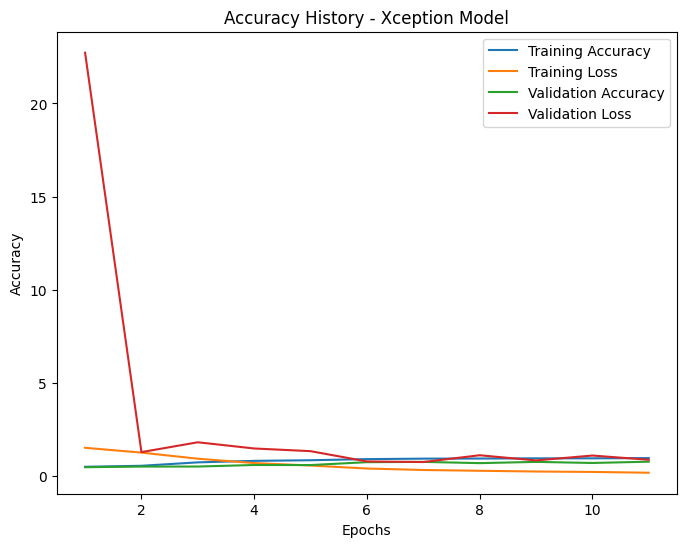

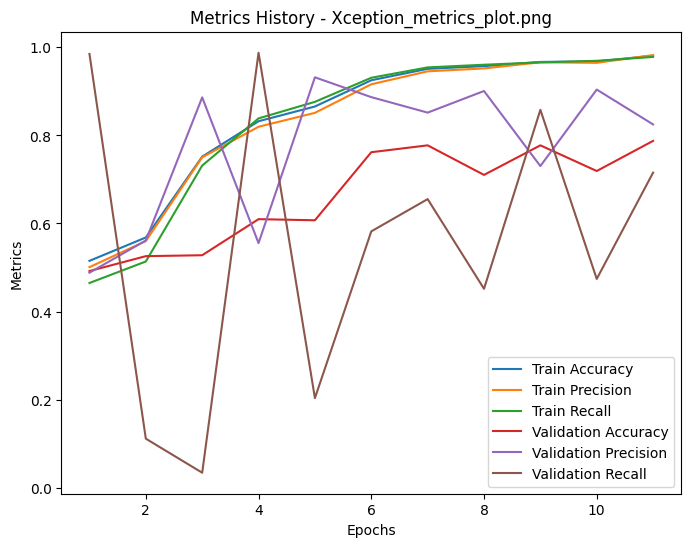

In [ ]:
# Experiment ID:TMC-0002 - Xception 
experimentId = "TMC-0003"

# Load Directories (Leave alone unless specifying a different dataset)
experiment_train_directory = train_directory
experiment_test_directory = test_directory
experiment_directory = f"{experiment_base_directory}/{experimentId}"
experiment_results_directory = f"{experiment_directory}/results"
experiment_models_directory = f"{experiment_directory}/models"

# Create directories if they don't exist
os.makedirs(name=experiment_directory, exist_ok=True)
os.makedirs(name=experiment_models_directory, exist_ok=True)
os.makedirs(name=experiment_results_directory, exist_ok=True)

# Declare lists for report generation
accuracy_report = []

# Declare Test Configurations
test_configurations = [
    [Xception, xception_preprocess_input]
]

# Define Early Stopping Callback
# Define callbacks
early_stopping = EarlyStopping(
    monitor='val_loss', 
    mode='min', 
    verbose=1, 
    patience=4
)

lr_reducer = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.25,
    patience=3,
    verbose=1,
)

model_checkpoint_accuracy = ModelCheckpoint(
    filepath=f"{experiment_models_directory}/model_highest_accuracy.h5",
    monitor="val_binary_accuracy",
    save_best_only=True,
    verbose=1, 
)

model_checkpoint_loss = ModelCheckpoint(
    filepath=f"{experiment_models_directory}/model_lowest_loss.h5",
    monitor="val_loss",
    save_best_only=True,
    verbose=1, 
)

callbacks = [early_stopping, lr_reducer, model_checkpoint_accuracy, model_checkpoint_loss]

# Loop through all combinations of models and trainable layers
for pretrained_model, preprocessing_function in test_configurations:
    K.clear_session()
    
    # Create a dataset and preprocess images to suit base model
    train_ds, val_ds = create_train_val_datasets(preprocessing_function, experiment_train_directory, batch_size=64, augment_data=False)
    test_ds = create_test_dataset(preprocessing_function, experiment_test_directory, batch_size=64)

    # Create Input Layer
    inputs = Input(shape=(299, 299, 3))

    # Create the base model from the pre-trained model
    base_model = pretrained_model(
        weights="imagenet", 
        include_top=False,
        input_tensor=inputs)

    # Make Base Model Trainable
    base_model.trainable = True
    
    # Freeze the base model (do not train everything but last 23 layers)
    for layer in base_model.layers[:-23]:
        layer.trainable = False
    
    # Add a classification head
    top_model = base_model.output
    top_model = GlobalAveragePooling2D()(top_model)
    top_model = Dense(256, kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4), activation='relu')(top_model)
    top_model = BatchNormalization()(top_model)
    top_model = Dropout(0.7)(top_model)
    top_model = Dense(256, kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4), activation='relu')(top_model)
    top_model = BatchNormalization()(top_model)
    top_model = Dropout(0.7)(top_model)
    top_model = Dense(256, kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4), activation='relu')(top_model)
    top_model = BatchNormalization()(top_model)
    top_model = Dropout(0.7)(top_model)
    top_model = Dense(256, kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4), activation='relu')(top_model)
    top_model = BatchNormalization()(top_model)
    top_model = Dropout(0.7)(top_model)
    top_model = Dense(1, activation='sigmoid')(top_model)
    model = Model(inputs=base_model.input, outputs=top_model)

    # Compile the model
    model.compile(
        optimizer=Adam(.01),  
        loss=BinaryCrossentropy(from_logits=False),
        metrics=[BinaryAccuracy(), Precision(), Recall(), AUC()]
    )
    
    # Create Model Image
    create_model_image(model, experiment_models_directory, name = f'{pretrained_model.__name__}_model', extension = 'png')
    
    # Start Timer to measure processing time 
    start_time = time.time()

    # Train the model but first clear history (Required to append results without errors)
    history = model.fit(
        train_ds, 
        steps_per_epoch=train_ds.samples // train_ds.batch_size,
        epochs=50, 
        validation_data=val_ds,
        validation_steps=val_ds.samples // val_ds.batch_size,
        callbacks = callbacks
    )
    
    # End Timer and calculate processing time
    end_time = time.time()
    processing_time = end_time - start_time

    # Evaluate the model
    evaluate = model.evaluate(test_ds, steps = test_ds.samples // test_ds.batch_size, verbose=1)
    
    # Append results to accuracy_test list
    history_key = list(history.history.keys()) # As names of metric names can be dynamic, we need to get the keys of the history object
    accuracy_report.append({
        'Base Model': pretrained_model.__name__,
        'duration': round(processing_time, 3),
        'test_accuracy': round(evaluate[1], 3),
        'test_precision': round(evaluate[2], 3),
        'test_recall': round(evaluate[3], 3),
        'test_loss': round(evaluate[0], 3),
        'train_accuracy': round(history.history[history_key[1]][-1],3),
        'train_precision': round(history.history[history_key[2]][-1],3),
        'train_recall': round(history.history[history_key[3]][-1],3),
        'train_auc' : round(history.history[history_key[4]][-1],3),
        'train_loss': round(history.history[history_key[0]][-1],3),
        'val_accuracy': round(history.history[history_key[6]][-1],3),
        'val_precision': round(history.history[history_key[7]][-1],3),
        'val_recall': round(history.history[history_key[8]][-1],3),
        'val_auc' : round(history.history[history_key[9]][-1],3),
        'val_loss': round(history.history[history_key[5]][-1],3)
    })
    
    epochs_report = pd.DataFrame(history.history)
    epochs_report.to_csv(f"{experiment_results_directory}/{pretrained_model.__name__}_epochs_report.csv", index=False)

# Create DataFrame with accuracy score and export as .csv
accuracy_test_results = pd.DataFrame(accuracy_report)
accuracy_test_results.to_csv(f'{experiment_results_directory}/accuracy_test_results.csv', index=False)

# Generate graphs from epochs_reports.csv and output to results folder.
create_accuracy_plots(f"{experiment_results_directory}")
create_all_metrics_plots(f"{experiment_results_directory}")

Found 9660 images belonging to 2 classes.
Found 2414 images belonging to 2 classes.
Found 4279 images belonging to 2 classes.
Epoch 1/50


2023-05-27 16:30:23.527166: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


150/150 [==============================] - ETA: 0s - loss: 2.5805 - binary_accuracy: 0.5059 - precision: 0.4915 - recall: 0.4849 - auc: 0.5120

2023-05-27 16:31:02.055357: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]



Epoch 1: val_binary_accuracy improved from -inf to 0.51014, saving model to ../experiments/top-model-configuration/TMC-0003/models/model_highest_accuracy.h5

Epoch 1: val_loss improved from inf to 4.61167, saving model to ../experiments/top-model-configuration/TMC-0003/models/model_lowest_loss.h5
150/150 [==============================] - 45s 271ms/step - loss: 2.5805 - binary_accuracy: 0.5059 - precision: 0.4915 - recall: 0.4849 - auc: 0.5120 - val_loss: 4.6117 - val_binary_accuracy: 0.5101 - val_precision: 0.4828 - val_recall: 0.1217 - val_auc: 0.5328 - lr: 0.0100
Epoch 2/50
150/150 [==============================] - ETA: 0s - loss: 2.1127 - binary_accuracy: 0.4906 - precision: 0.4747 - recall: 0.4671 - auc: 0.4959
Epoch 2: val_binary_accuracy did not improve from 0.51014

Epoch 2: val_loss improved from 4.61167 to 2.15197, saving model to ../experiments/top-model-configuration/TMC-0003/models/model_lowest_loss.h5
150/150 [==============================] - 40s 265ms/step - loss: 2.1

2023-05-27 16:43:38.662201: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


66/66 [==============================] - 11s 157ms/step - loss: 0.5838 - binary_accuracy: 0.8660 - precision: 0.8233 - recall: 0.9226 - auc: 0.9460


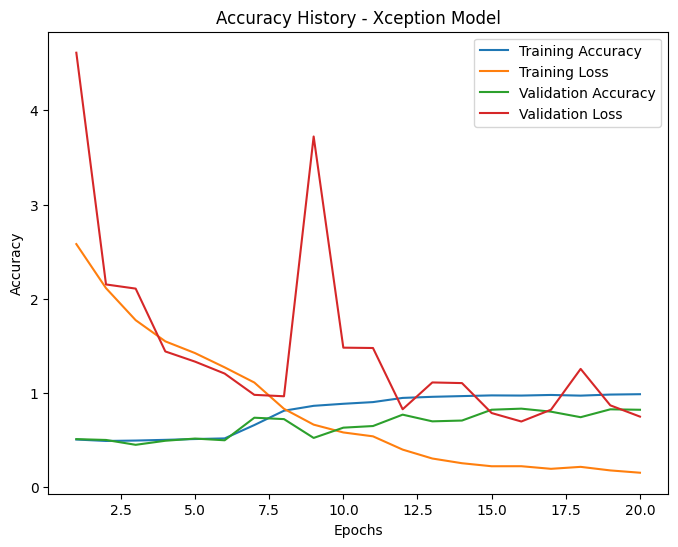

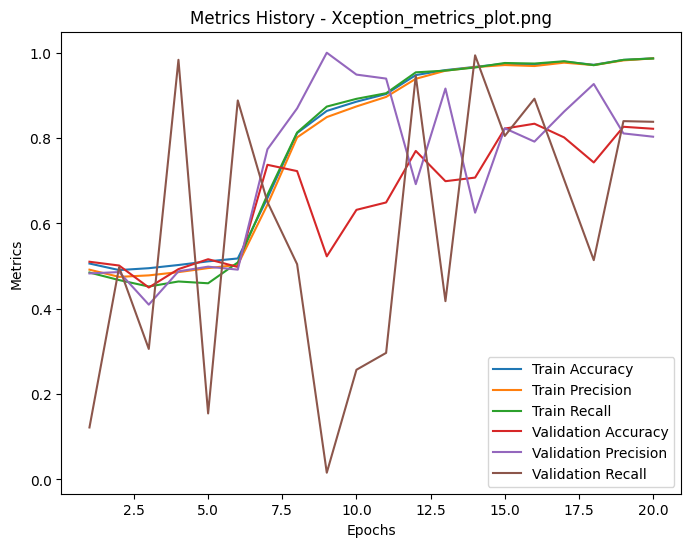

In [ ]:
# Experiment ID:TMC-0004 - Xception 
experimentId = "TMC-0004"

# Load Directories (Leave alone unless specifying a different dataset)
experiment_train_directory = train_directory
experiment_test_directory = test_directory
experiment_directory = f"{experiment_base_directory}/{experimentId}"
experiment_results_directory = f"{experiment_directory}/results"
experiment_models_directory = f"{experiment_directory}/models"

# Create directories if they don't exist
os.makedirs(name=experiment_directory, exist_ok=True)
os.makedirs(name=experiment_models_directory, exist_ok=True)
os.makedirs(name=experiment_results_directory, exist_ok=True)

# Declare lists for report generation
accuracy_report = []

# Declare Test Configurations
test_configurations = [
    [Xception, xception_preprocess_input]
]

# Define Early Stopping Callback
# Define callbacks
early_stopping = EarlyStopping(
    monitor='val_loss', 
    mode='min', 
    verbose=1, 
    patience=4
)

lr_reducer = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.25,
    patience=3,
    verbose=1,
)

model_checkpoint_accuracy = ModelCheckpoint(
    filepath=f"{experiment_models_directory}/model_highest_accuracy.h5",
    monitor="val_binary_accuracy",
    save_best_only=True,
    verbose=1, 
)

model_checkpoint_loss = ModelCheckpoint(
    filepath=f"{experiment_models_directory}/model_lowest_loss.h5",
    monitor="val_loss",
    save_best_only=True,
    verbose=1, 
)

callbacks = [early_stopping, lr_reducer, model_checkpoint_accuracy, model_checkpoint_loss]

# Loop through all combinations of models and trainable layers
for pretrained_model, preprocessing_function in test_configurations:
    K.clear_session()
    
    # Create a dataset and preprocess images to suit base model
    train_ds, val_ds = create_train_val_datasets(preprocessing_function, experiment_train_directory, batch_size=64, augment_data=False)
    test_ds = create_test_dataset(preprocessing_function, experiment_test_directory, batch_size=64)

    # Create Input Layer
    inputs = Input(shape=(299, 299, 3))

    # Create the base model from the pre-trained model
    base_model = pretrained_model(
        weights="imagenet", 
        include_top=False,
        input_tensor=inputs)

    # Make Base Model Trainable
    base_model.trainable = True
    
    # Freeze the base model (do not train everything but last 23 layers)
    for layer in base_model.layers[:-23]:
        layer.trainable = False
    
    # Add a classification head
    top_model = base_model.output
    top_model = GlobalAveragePooling2D()(top_model)
    top_model = Dense(512, kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4), activation='relu')(top_model)
    top_model = BatchNormalization()(top_model)
    top_model = Dropout(0.7)(top_model)
    top_model = Dense(512, kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4), activation='relu')(top_model)
    top_model = BatchNormalization()(top_model)
    top_model = Dropout(0.7)(top_model)
    top_model = Dense(512, kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4), activation='relu')(top_model)
    top_model = BatchNormalization()(top_model)
    top_model = Dropout(0.7)(top_model)
    top_model = Dense(512, kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4), activation='relu')(top_model)
    top_model = BatchNormalization()(top_model)
    top_model = Dropout(0.7)(top_model)
    top_model = Dense(1, activation='sigmoid')(top_model)
    model = Model(inputs=base_model.input, outputs=top_model)

    # Compile the model
    model.compile(
        optimizer=Adam(.01),  
        loss=BinaryCrossentropy(from_logits=False),
        metrics=[BinaryAccuracy(), Precision(), Recall(), AUC()]
    )
    
    # Create Model Image
    create_model_image(model, experiment_models_directory, name = f'{pretrained_model.__name__}_model', extension = 'png')
    
    # Start Timer to measure processing time 
    start_time = time.time()

    # Train the model but first clear history (Required to append results without errors)
    history = model.fit(
        train_ds, 
        steps_per_epoch=train_ds.samples // train_ds.batch_size,
        epochs=50, 
        validation_data=val_ds,
        validation_steps=val_ds.samples // val_ds.batch_size,
        callbacks = callbacks
    )
    
    # End Timer and calculate processing time
    end_time = time.time()
    processing_time = end_time - start_time

    # Evaluate the model
    evaluate = model.evaluate(test_ds, steps = test_ds.samples // test_ds.batch_size, verbose=1)
    
    # Append results to accuracy_test list
    history_key = list(history.history.keys()) # As names of metric names can be dynamic, we need to get the keys of the history object
    accuracy_report.append({
        'Base Model': pretrained_model.__name__,
        'duration': round(processing_time, 3),
        'test_accuracy': round(evaluate[1], 3),
        'test_precision': round(evaluate[2], 3),
        'test_recall': round(evaluate[3], 3),
        'test_loss': round(evaluate[0], 3),
        'train_accuracy': round(history.history[history_key[1]][-1],3),
        'train_precision': round(history.history[history_key[2]][-1],3),
        'train_recall': round(history.history[history_key[3]][-1],3),
        'train_auc' : round(history.history[history_key[4]][-1],3),
        'train_loss': round(history.history[history_key[0]][-1],3),
        'val_accuracy': round(history.history[history_key[6]][-1],3),
        'val_precision': round(history.history[history_key[7]][-1],3),
        'val_recall': round(history.history[history_key[8]][-1],3),
        'val_auc' : round(history.history[history_key[9]][-1],3),
        'val_loss': round(history.history[history_key[5]][-1],3)
    })
    
    epochs_report = pd.DataFrame(history.history)
    epochs_report.to_csv(f"{experiment_results_directory}/{pretrained_model.__name__}_epochs_report.csv", index=False)

# Create DataFrame with accuracy score and export as .csv
accuracy_test_results = pd.DataFrame(accuracy_report)
accuracy_test_results.to_csv(f'{experiment_results_directory}/accuracy_test_results.csv', index=False)

# Generate graphs from epochs_reports.csv and output to results folder.
create_accuracy_plots(f"{experiment_results_directory}")
create_all_metrics_plots(f"{experiment_results_directory}")

Found 9660 images belonging to 2 classes.
Found 2414 images belonging to 2 classes.
Found 4279 images belonging to 2 classes.
Epoch 1/50


2023-05-27 16:43:51.922358: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


150/150 [==============================] - ETA: 0s - loss: 6.4838 - binary_accuracy: 0.6604 - precision: 0.6581 - recall: 0.6258 - auc: 0.7106

2023-05-27 16:44:29.807162: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]



Epoch 1: val_binary_accuracy improved from -inf to 0.52492, saving model to ../experiments/top-model-configuration/TMC-0004/models/model_highest_accuracy.h5

Epoch 1: val_loss improved from inf to 27.52777, saving model to ../experiments/top-model-configuration/TMC-0004/models/model_lowest_loss.h5
150/150 [==============================] - 45s 270ms/step - loss: 6.4838 - binary_accuracy: 0.6604 - precision: 0.6581 - recall: 0.6258 - auc: 0.7106 - val_loss: 27.5278 - val_binary_accuracy: 0.5249 - val_precision: 0.8889 - val_recall: 0.0209 - val_auc: 0.5360 - lr: 0.0100
Epoch 2/50
150/150 [==============================] - ETA: 0s - loss: 3.2584 - binary_accuracy: 0.7712 - precision: 0.7636 - recall: 0.7656 - auc: 0.8453
Epoch 2: val_binary_accuracy improved from 0.52492 to 0.54054, saving model to ../experiments/top-model-configuration/TMC-0004/models/model_highest_accuracy.h5

Epoch 2: val_loss improved from 27.52777 to 3.92805, saving model to ../experiments/top-model-configuration/T

2023-05-27 16:55:53.340964: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


66/66 [==============================] - 11s 157ms/step - loss: 0.5311 - binary_accuracy: 0.8613 - precision: 0.8857 - recall: 0.8212 - auc: 0.9389


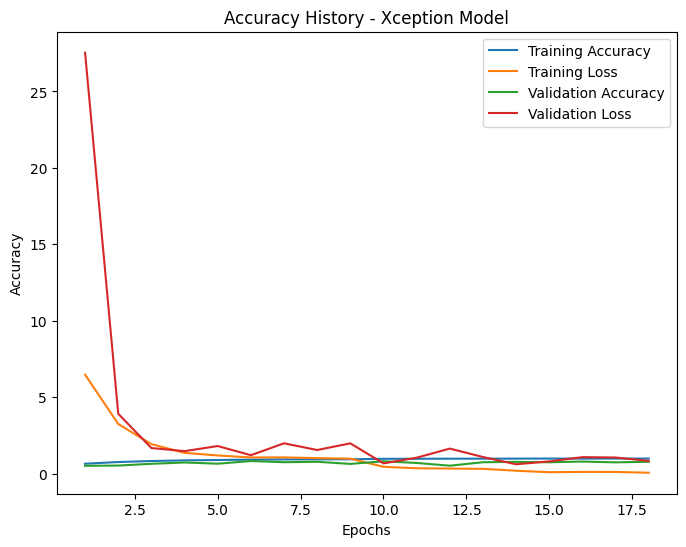

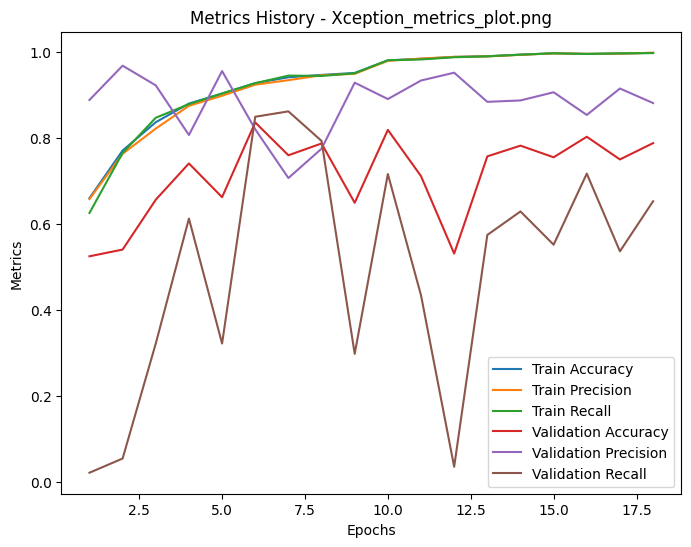

In [ ]:
# Experiment ID:TMC-0005 - Xception 
experimentId = "TMC-0005"

# Load Directories (Leave alone unless specifying a different dataset)
experiment_train_directory = train_directory
experiment_test_directory = test_directory
experiment_directory = f"{experiment_base_directory}/{experimentId}"
experiment_results_directory = f"{experiment_directory}/results"
experiment_models_directory = f"{experiment_directory}/models"

# Create directories if they don't exist
os.makedirs(name=experiment_directory, exist_ok=True)
os.makedirs(name=experiment_models_directory, exist_ok=True)
os.makedirs(name=experiment_results_directory, exist_ok=True)

# Declare lists for report generation
accuracy_report = []

# Declare Test Configurations
test_configurations = [
    [Xception, xception_preprocess_input]
]

# Define Early Stopping Callback
# Define callbacks
early_stopping = EarlyStopping(
    monitor='val_loss', 
    mode='min', 
    verbose=1, 
    patience=4
)

lr_reducer = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.25,
    patience=3,
    verbose=1,
)

model_checkpoint_accuracy = ModelCheckpoint(
    filepath=f"{experiment_models_directory}/model_highest_accuracy.h5",
    monitor="val_binary_accuracy",
    save_best_only=True,
    verbose=1, 
)

model_checkpoint_loss = ModelCheckpoint(
    filepath=f"{experiment_models_directory}/model_lowest_loss.h5",
    monitor="val_loss",
    save_best_only=True,
    verbose=1, 
)

callbacks = [early_stopping, lr_reducer, model_checkpoint_accuracy, model_checkpoint_loss]

# Loop through all combinations of models and trainable layers
for pretrained_model, preprocessing_function in test_configurations:
    K.clear_session()
    
    # Create a dataset and preprocess images to suit base model
    train_ds, val_ds = create_train_val_datasets(preprocessing_function, experiment_train_directory, batch_size=64, augment_data=False)
    test_ds = create_test_dataset(preprocessing_function, experiment_test_directory, batch_size=64)

    # Create Input Layer
    inputs = Input(shape=(299, 299, 3))

    # Create the base model from the pre-trained model
    base_model = pretrained_model(
        weights="imagenet", 
        include_top=False,
        input_tensor=inputs)

    # Make Base Model Trainable
    base_model.trainable = True
    
    # Freeze the base model (do not train everything but last 23 layers)
    for layer in base_model.layers[:-23]:
        layer.trainable = False
    
    # Add a classification head
    top_model = base_model.output
    top_model = GlobalAveragePooling2D()(top_model)
    top_model = Dense(3070, kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4))(top_model)
    top_model = BatchNormalization()(top_model)
    top_model = Activation('relu')(top_model)
    top_model = Dropout(0.7)(top_model)
    top_model = Dense(2048, kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4))(top_model)
    top_model = BatchNormalization()(top_model)
    top_model = Activation('relu')(top_model)
    top_model = Dropout(0.5)(top_model)
    top_model = Dense(1024, kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4))(top_model)
    top_model = BatchNormalization()(top_model)
    top_model = Activation('relu')(top_model)
    top_model = Dropout(0.2)(top_model)
    top_model = Dense(1, activation='sigmoid')(top_model)
    model = Model(inputs=base_model.input, outputs=top_model)

    # Compile the model
    model.compile(
        optimizer=Adam(.01),  
        loss=BinaryCrossentropy(from_logits=False),
        metrics=[BinaryAccuracy(), Precision(), Recall(), AUC()]
    )
    
    # Create Model Image
    create_model_image(model, experiment_models_directory, name = f'{pretrained_model.__name__}_model', extension = 'png')
    
    # Start Timer to measure processing time 
    start_time = time.time()

    # Train the model but first clear history (Required to append results without errors)
    history = model.fit(
        train_ds, 
        steps_per_epoch=train_ds.samples // train_ds.batch_size,
        epochs=50, 
        validation_data=val_ds,
        validation_steps=val_ds.samples // val_ds.batch_size,
        callbacks = callbacks
    )
    
    # End Timer and calculate processing time
    end_time = time.time()
    processing_time = end_time - start_time

    # Evaluate the model
    evaluate = model.evaluate(test_ds, steps = test_ds.samples // test_ds.batch_size, verbose=1)
    
    # Append results to accuracy_test list
    history_key = list(history.history.keys()) # As names of metric names can be dynamic, we need to get the keys of the history object
    accuracy_report.append({
        'Base Model': pretrained_model.__name__,
        'duration': round(processing_time, 3),
        'test_accuracy': round(evaluate[1], 3),
        'test_precision': round(evaluate[2], 3),
        'test_recall': round(evaluate[3], 3),
        'test_loss': round(evaluate[0], 3),
        'train_accuracy': round(history.history[history_key[1]][-1],3),
        'train_precision': round(history.history[history_key[2]][-1],3),
        'train_recall': round(history.history[history_key[3]][-1],3),
        'train_auc' : round(history.history[history_key[4]][-1],3),
        'train_loss': round(history.history[history_key[0]][-1],3),
        'val_accuracy': round(history.history[history_key[6]][-1],3),
        'val_precision': round(history.history[history_key[7]][-1],3),
        'val_recall': round(history.history[history_key[8]][-1],3),
        'val_auc' : round(history.history[history_key[9]][-1],3),
        'val_loss': round(history.history[history_key[5]][-1],3)
    })
    
    epochs_report = pd.DataFrame(history.history)
    epochs_report.to_csv(f"{experiment_results_directory}/{pretrained_model.__name__}_epochs_report.csv", index=False)

# Create DataFrame with accuracy score and export as .csv
accuracy_test_results = pd.DataFrame(accuracy_report)
accuracy_test_results.to_csv(f'{experiment_results_directory}/accuracy_test_results.csv', index=False)

# Generate graphs from epochs_reports.csv and output to results folder.
create_accuracy_plots(f"{experiment_results_directory}")
create_all_metrics_plots(f"{experiment_results_directory}")

Found 9660 images belonging to 2 classes.
Found 2414 images belonging to 2 classes.
Found 4279 images belonging to 2 classes.
Epoch 1/50


2023-05-27 17:10:58.125869: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


150/150 [==============================] - ETA: 0s - loss: 6.0544 - binary_accuracy: 0.5047 - precision: 0.4879 - recall: 0.4295 - auc: 0.4972

2023-05-27 17:11:36.130111: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]



Epoch 1: val_binary_accuracy improved from -inf to 0.48395, saving model to ../experiments/top-model-configuration/TMC-0004/models/model_highest_accuracy.h5

Epoch 1: val_loss improved from inf to 2.87740, saving model to ../experiments/top-model-configuration/TMC-0004/models/model_lowest_loss.h5
150/150 [==============================] - 45s 269ms/step - loss: 6.0544 - binary_accuracy: 0.5047 - precision: 0.4879 - recall: 0.4295 - auc: 0.4972 - val_loss: 2.8774 - val_binary_accuracy: 0.4840 - val_precision: 0.4839 - val_recall: 0.9426 - val_auc: 0.5269 - lr: 0.0100
Epoch 2/50
150/150 [==============================] - ETA: 0s - loss: 2.8726 - binary_accuracy: 0.6970 - precision: 0.7036 - recall: 0.6489 - auc: 0.7681
Epoch 2: val_binary_accuracy improved from 0.48395 to 0.59713, saving model to ../experiments/top-model-configuration/TMC-0004/models/model_highest_accuracy.h5

Epoch 2: val_loss improved from 2.87740 to 2.85376, saving model to ../experiments/top-model-configuration/TMC-

2023-05-27 17:19:39.043676: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


66/66 [==============================] - 11s 157ms/step - loss: 0.4118 - binary_accuracy: 0.8724 - precision: 0.8337 - recall: 0.9211 - auc: 0.9465


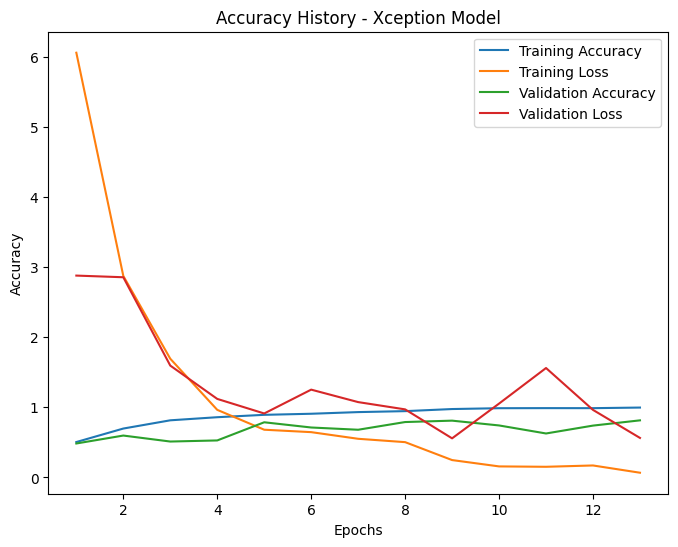

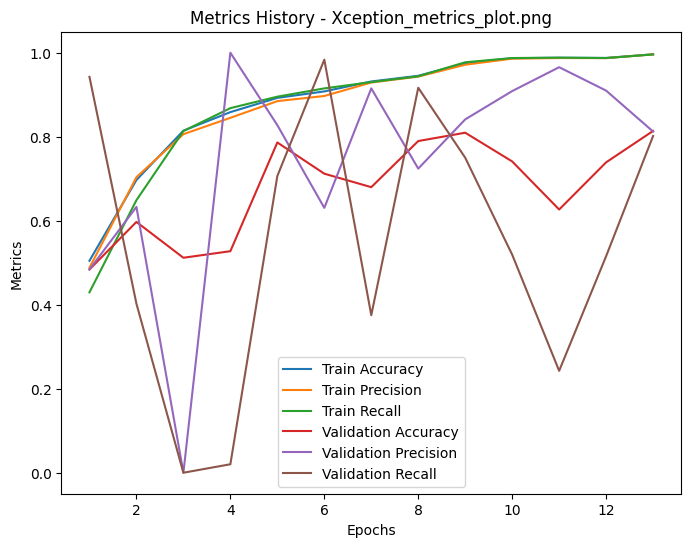

In [ ]:
# Experiment ID:TMC-0006 - Xception 
experimentId = "TMC-0006"

# Load Directories (Leave alone unless specifying a different dataset)
experiment_train_directory = train_directory
experiment_test_directory = test_directory
experiment_directory = f"{experiment_base_directory}/{experimentId}"
experiment_results_directory = f"{experiment_directory}/results"
experiment_models_directory = f"{experiment_directory}/models"

# Create directories if they don't exist
os.makedirs(name=experiment_directory, exist_ok=True)
os.makedirs(name=experiment_models_directory, exist_ok=True)
os.makedirs(name=experiment_results_directory, exist_ok=True)

# Declare lists for report generation
accuracy_report = []

# Declare Test Configurations
test_configurations = [
    [Xception, xception_preprocess_input]
]

# Define Early Stopping Callback
# Define callbacks
early_stopping = EarlyStopping(
    monitor='val_loss', 
    mode='min', 
    verbose=1, 
    patience=4
)

lr_reducer = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.25,
    patience=3,
    verbose=1,
)

model_checkpoint_accuracy = ModelCheckpoint(
    filepath=f"{experiment_models_directory}/model_highest_accuracy.h5",
    monitor="val_binary_accuracy",
    save_best_only=True,
    verbose=1, 
)

model_checkpoint_loss = ModelCheckpoint(
    filepath=f"{experiment_models_directory}/model_lowest_loss.h5",
    monitor="val_loss",
    save_best_only=True,
    verbose=1, 
)

callbacks = [early_stopping, lr_reducer, model_checkpoint_accuracy, model_checkpoint_loss]

# Loop through all combinations of models and trainable layers
for pretrained_model, preprocessing_function in test_configurations:
    K.clear_session()
    
    # Create a dataset and preprocess images to suit base model
    train_ds, val_ds = create_train_val_datasets(preprocessing_function, experiment_train_directory, batch_size=32, augment_data=True)
    test_ds = create_test_dataset(preprocessing_function, experiment_test_directory, batch_size=32)

    # Create Input Layer
    inputs = Input(shape=(299, 299, 3))

    # Create the base model from the pre-trained model
    base_model = pretrained_model(
        weights="imagenet", 
        include_top=False,
        input_tensor=inputs)

    # Make Base Model Trainable
    base_model.trainable = True
    
    # Freeze the base model (do not train everything but last 23 layers)
    for layer in base_model.layers[:-23]:
        layer.trainable = False
    
    # Add a classification head
    top_model = base_model.output
    top_model = GlobalAveragePooling2D()(top_model)
    top_model = Dense(2048, kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4))(top_model)
    top_model = Dropout(0.5)(top_model)
    top_model = BatchNormalization()(top_model)
    top_model = Activation('relu')(top_model)
    top_model = Dense(2048, kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4))(top_model)
    top_model = Dropout(0.5)(top_model)
    top_model = BatchNormalization()(top_model)
    top_model = Activation('relu')(top_model)
    top_model = Dense(2048, kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4))(top_model)
    top_model = Dropout(0.5)(top_model)
    top_model = BatchNormalization()(top_model)
    top_model = Activation('relu')(top_model)
    top_model = Dense(1, activation='sigmoid')(top_model)
    model = Model(inputs=base_model.input, outputs=top_model)

    # Compile the model
    model.compile(
        optimizer=Adam(.01),  
        loss=BinaryCrossentropy(from_logits=False),
        metrics=[BinaryAccuracy(), Precision(), Recall(), AUC()]
    )
    
    # Create Model Image
    create_model_image(model, experiment_models_directory, name = f'{pretrained_model.__name__}_model', extension = 'png')
    
    # Start Timer to measure processing time 
    start_time = time.time()

    # Train the model but first clear history (Required to append results without errors)
    history = model.fit(
        train_ds, 
        steps_per_epoch=train_ds.samples // train_ds.batch_size,
        epochs=50, 
        validation_data=val_ds,
        validation_steps=val_ds.samples // val_ds.batch_size,
        callbacks = callbacks
    )
    
    # End Timer and calculate processing time
    end_time = time.time()
    processing_time = end_time - start_time

    # Evaluate the model
    evaluate = model.evaluate(test_ds, steps = test_ds.samples // test_ds.batch_size, verbose=1)
    
    # Append results to accuracy_test list
    history_key = list(history.history.keys()) # As names of metric names can be dynamic, we need to get the keys of the history object
    accuracy_report.append({
        'Base Model': pretrained_model.__name__,
        'duration': round(processing_time, 3),
        'test_accuracy': round(evaluate[1], 3),
        'test_precision': round(evaluate[2], 3),
        'test_recall': round(evaluate[3], 3),
        'test_loss': round(evaluate[0], 3),
        'train_accuracy': round(history.history[history_key[1]][-1],3),
        'train_precision': round(history.history[history_key[2]][-1],3),
        'train_recall': round(history.history[history_key[3]][-1],3),
        'train_auc' : round(history.history[history_key[4]][-1],3),
        'train_loss': round(history.history[history_key[0]][-1],3),
        'val_accuracy': round(history.history[history_key[6]][-1],3),
        'val_precision': round(history.history[history_key[7]][-1],3),
        'val_recall': round(history.history[history_key[8]][-1],3),
        'val_auc' : round(history.history[history_key[9]][-1],3),
        'val_loss': round(history.history[history_key[5]][-1],3)
    })
    
    epochs_report = pd.DataFrame(history.history)
    epochs_report.to_csv(f"{experiment_results_directory}/{pretrained_model.__name__}_epochs_report.csv", index=False)

# Create DataFrame with accuracy score and export as .csv
accuracy_test_results = pd.DataFrame(accuracy_report)
accuracy_test_results.to_csv(f'{experiment_results_directory}/accuracy_test_results.csv', index=False)

# Generate graphs from epochs_reports.csv and output to results folder.
create_accuracy_plots(f"{experiment_results_directory}")
create_all_metrics_plots(f"{experiment_results_directory}")

Found 9660 images belonging to 2 classes.
Found 2414 images belonging to 2 classes.
Found 4279 images belonging to 2 classes.
Epoch 1/50


2023-05-27 17:31:11.465771: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-05-27 17:31:13.984381: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 916.00MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-05-27 17:31:15.215041: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 628.00MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-05-27 17:31:16.829773: W tensorflow/tsl/framework/bfc_alloc

  6/150 [>.............................] - ETA: 55s - loss: 7.3893 - binary_accuracy: 0.5156 - precision: 0.5026 - recall: 0.5134 - auc: 0.5380

2023-05-27 17:31:24.058284: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 916.00MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-05-27 17:31:24.925297: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 625.75MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-05-27 17:31:26.172431: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 736.00MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-05-27 17:31:28.384642: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocato

150/150 [==============================] - ETA: 0s - loss: 2.9154 - binary_accuracy: 0.5516 - precision: 0.5396 - recall: 0.5144 - auc: 0.5615

2023-05-27 17:32:24.459347: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]



Epoch 1: val_binary_accuracy improved from -inf to 0.52618, saving model to ../experiments/top-model-configuration/TMC-0006/models/model_highest_accuracy.h5

Epoch 1: val_loss improved from inf to 2.59271, saving model to ../experiments/top-model-configuration/TMC-0006/models/model_lowest_loss.h5
150/150 [==============================] - 84s 491ms/step - loss: 2.9154 - binary_accuracy: 0.5516 - precision: 0.5396 - recall: 0.5144 - auc: 0.5615 - val_loss: 2.5927 - val_binary_accuracy: 0.5262 - val_precision: 0.5349 - val_recall: 0.1802 - val_auc: 0.5555 - lr: 0.0100
Epoch 2/50
150/150 [==============================] - ETA: 0s - loss: 1.0503 - binary_accuracy: 0.7552 - precision: 0.7475 - recall: 0.7480 - auc: 0.8263
Epoch 2: val_binary_accuracy improved from 0.52618 to 0.60895, saving model to ../experiments/top-model-configuration/TMC-0006/models/model_highest_accuracy.h5

Epoch 2: val_loss improved from 2.59271 to 1.19241, saving model to ../experiments/top-model-configuration/TMC-

2023-05-27 17:43:44.322389: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


66/66 [==============================] - 14s 208ms/step - loss: 0.4496 - binary_accuracy: 0.8587 - precision: 0.8847 - recall: 0.8164 - auc: 0.9274


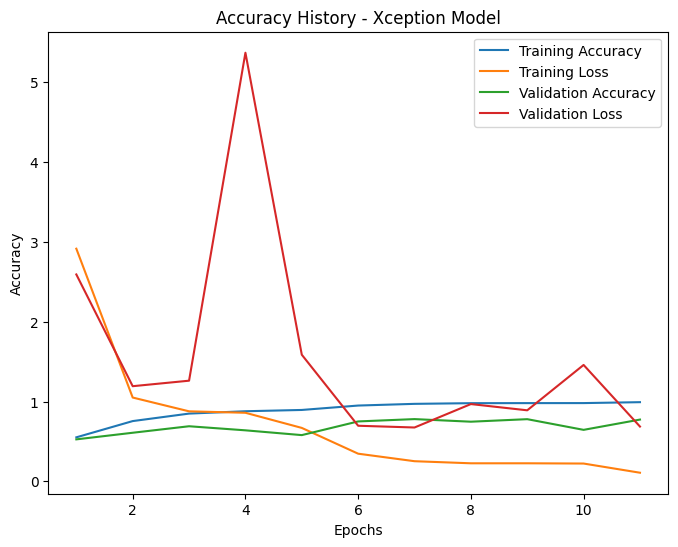

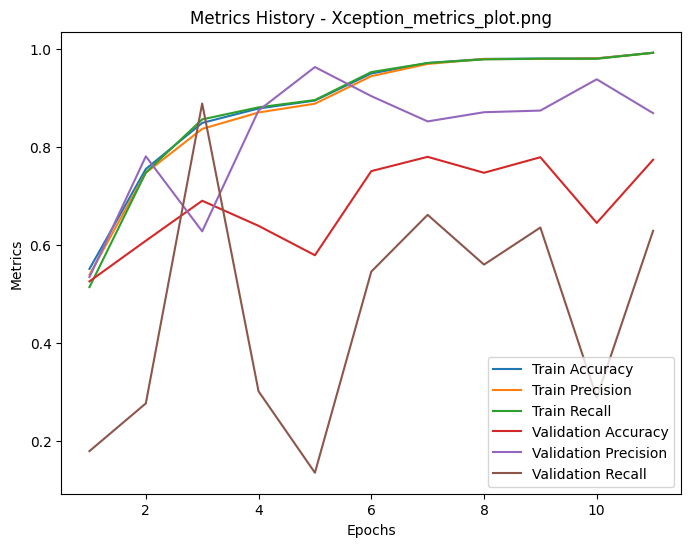

In [ ]:
# Experiment ID:TMC-0007 - Xception 
experimentId = "TMC-0008"

# Load Directories (Leave alone unless specifying a different dataset)
experiment_train_directory = train_directory
experiment_test_directory = test_directory
experiment_directory = f"{experiment_base_directory}/{experimentId}"
experiment_results_directory = f"{experiment_directory}/results"
experiment_models_directory = f"{experiment_directory}/models"

# Create directories if they don't exist
os.makedirs(name=experiment_directory, exist_ok=True)
os.makedirs(name=experiment_models_directory, exist_ok=True)
os.makedirs(name=experiment_results_directory, exist_ok=True)

# Declare lists for report generation
accuracy_report = []

# Declare Test Configurations
test_configurations = [
    [Xception, xception_preprocess_input]
]

# Define Early Stopping Callback
# Define callbacks
early_stopping = EarlyStopping(
    monitor='val_loss', 
    mode='min', 
    verbose=1, 
    patience=4
)

lr_reducer = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.25,
    patience=3,
    verbose=1,
)

model_checkpoint_accuracy = ModelCheckpoint(
    filepath=f"{experiment_models_directory}/model_highest_accuracy.h5",
    monitor="val_binary_accuracy",
    save_best_only=True,
    verbose=1, 
)

model_checkpoint_loss = ModelCheckpoint(
    filepath=f"{experiment_models_directory}/model_lowest_loss.h5",
    monitor="val_loss",
    save_best_only=True,
    verbose=1, 
)

callbacks = [early_stopping, lr_reducer, model_checkpoint_accuracy, model_checkpoint_loss]

# Loop through all combinations of models and trainable layers
for pretrained_model, preprocessing_function in test_configurations:
    K.clear_session()
    
    # Create a dataset and preprocess images to suit base model
    train_ds, val_ds = create_train_val_datasets(preprocessing_function, experiment_train_directory, batch_size=32, augment_data=True)
    test_ds = create_test_dataset(preprocessing_function, experiment_test_directory, batch_size=32)

    # Create Input Layer
    inputs = Input(shape=(299, 299, 3))

    # Create the base model from the pre-trained model
    base_model = pretrained_model(
        weights="imagenet", 
        include_top=False,
        input_tensor=inputs)

    # Make Base Model Trainable
    base_model.trainable = True
    
    # Freeze the base model (do not train everything but last 23 layers)
    for layer in base_model.layers[:-23]:
        layer.trainable = False
    
    top_model = base_model.output
    top_model = Conv2D(2048, (3, 3), padding='same', activation='relu')(top_model)
    top_model = MaxPooling2D(pool_size=(2, 2))(top_model)
    top_model = BatchNormalization()(top_model)

    top_model = Conv2D(2048, (3, 3), padding='same', activation='relu')(top_model)
    top_model = MaxPooling2D(pool_size=(2, 2))(top_model)
    top_model = BatchNormalization()(top_model)
    
    

    top_model = Conv2D(1024, (3, 3), padding='same', activation='relu')(top_model)
    top_model = MaxPooling2D(pool_size=(2, 2))(top_model)
    top_model = BatchNormalization()(top_model)

    top_model = Flatten()(top_model)
    top_model = Dense(1024, activation='relu', kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4))(top_model)
    top_model = Dropout(0.5)(top_model)
    top_model = BatchNormalization()(top_model)
    top_model = Dense(1, activation='sigmoid')(top_model)

    model = Model(inputs=base_model.input, outputs=top_model)

    # Compile the model
    model.compile(
        optimizer=Adam(.01),  
        loss=BinaryCrossentropy(from_logits=False),
        metrics=[BinaryAccuracy(), Precision(), Recall(), AUC()]
    )
    
    # Create Model Image
    create_model_image(model, experiment_models_directory, name = f'{pretrained_model.__name__}_model', extension = 'png')
    
    # Start Timer to measure processing time 
    start_time = time.time()

    # Train the model but first clear history (Required to append results without errors)
    history = model.fit(
        train_ds, 
        steps_per_epoch=train_ds.samples // train_ds.batch_size,
        epochs=50, 
        validation_data=val_ds,
        validation_steps=val_ds.samples // val_ds.batch_size,
        callbacks = callbacks
    )
    
    # End Timer and calculate processing time
    end_time = time.time()
    processing_time = end_time - start_time

    # Evaluate the model
    evaluate = model.evaluate(test_ds, steps = test_ds.samples // test_ds.batch_size, verbose=1)
    
    # Append results to accuracy_test list
    history_key = list(history.history.keys()) # As names of metric names can be dynamic, we need to get the keys of the history object
    accuracy_report.append({
        'Base Model': pretrained_model.__name__,
        'duration': round(processing_time, 3),
        'test_accuracy': round(evaluate[1], 3),
        'test_precision': round(evaluate[2], 3),
        'test_recall': round(evaluate[3], 3),
        'test_loss': round(evaluate[0], 3),
        'train_accuracy': round(history.history[history_key[1]][-1],3),
        'train_precision': round(history.history[history_key[2]][-1],3),
        'train_recall': round(history.history[history_key[3]][-1],3),
        'train_auc' : round(history.history[history_key[4]][-1],3),
        'train_loss': round(history.history[history_key[0]][-1],3),
        'val_accuracy': round(history.history[history_key[6]][-1],3),
        'val_precision': round(history.history[history_key[7]][-1],3),
        'val_recall': round(history.history[history_key[8]][-1],3),
        'val_auc' : round(history.history[history_key[9]][-1],3),
        'val_loss': round(history.history[history_key[5]][-1],3)
    })
    
    epochs_report = pd.DataFrame(history.history)
    epochs_report.to_csv(f"{experiment_results_directory}/{pretrained_model.__name__}_epochs_report.csv", index=False)

# Create DataFrame with accuracy score and export as .csv
accuracy_test_results = pd.DataFrame(accuracy_report)
accuracy_test_results.to_csv(f'{experiment_results_directory}/accuracy_test_results.csv', index=False)

# Generate graphs from epochs_reports.csv and output to results folder.
create_accuracy_plots(f"{experiment_results_directory}")
create_all_metrics_plots(f"{experiment_results_directory}")

In [ ]:
# Experiment ID:TMC-0009 - Xception 
experimentId = "TMC-0009"

# Load Directories (Leave alone unless specifying a different dataset)
experiment_train_directory = train_directory
experiment_test_directory = test_directory
experiment_directory = f"{experiment_base_directory}/{experimentId}"
experiment_results_directory = f"{experiment_directory}/results"
experiment_models_directory = f"{experiment_directory}/models"

# Create directories if they don't exist
os.makedirs(name=experiment_directory, exist_ok=True)
os.makedirs(name=experiment_models_directory, exist_ok=True)
os.makedirs(name=experiment_results_directory, exist_ok=True)

# Declare lists for report generation
accuracy_report = []

# Declare Test Configurations
test_configurations = [
    [Xception, xception_preprocess_input]
]

# Define Early Stopping Callback
# Define callbacks
early_stopping = EarlyStopping(
    monitor='val_loss', 
    mode='min', 
    verbose=1, 
    patience=10
)

lr_reducer = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.25,
    patience=3,
    verbose=1,
)

model_checkpoint_accuracy = ModelCheckpoint(
    filepath=f"{experiment_models_directory}/model_highest_accuracy.h5",
    monitor="val_binary_accuracy",
    save_best_only=True,
    verbose=1, 
)

model_checkpoint_loss = ModelCheckpoint(
    filepath=f"{experiment_models_directory}/model_lowest_loss.h5",
    monitor="val_loss",
    save_best_only=True,
    verbose=1, 
)

callbacks = [early_stopping, lr_reducer, model_checkpoint_accuracy, model_checkpoint_loss]

# Loop through all combinations of models and trainable layers
for pretrained_model, preprocessing_function in test_configurations:
    K.clear_session()
    
    # Create a dataset and preprocess images to suit base model
    train_ds, val_ds = create_train_val_datasets(preprocessing_function, experiment_train_directory, batch_size=64, augment_data=False)
    test_ds = create_test_dataset(preprocessing_function, experiment_test_directory, batch_size=64)

    # Create Input Layer
    inputs = Input(shape=(299, 299, 3))

    # Create the base model from the pre-trained model
    base_model = pretrained_model(
        weights="imagenet", 
        include_top=False,
        input_tensor=inputs)

    # Make Base Model Trainable
    base_model.trainable = True
    
    # Freeze the base model (do not train everything but last 23 layers)
    for layer in base_model.layers[:-23]:
        layer.trainable = False
    
    # Add a classification head
    top_model = base_model.output
    top_model = Conv2D(2048, (3, 3), padding='same')(top_model)
    top_model = BatchNormalization()(top_model)
    top_model = Activation('relu')(top_model)
    top_model = MaxPooling2D(pool_size=(2, 2))(top_model)
    top_model = Dropout(0.8)(top_model)

    top_model = Conv2D(2048, (3, 3), padding='same')(top_model)
    top_model = BatchNormalization()(top_model)
    top_model = Activation('relu')(top_model)
    top_model = MaxPooling2D(pool_size=(2, 2))(top_model)
    top_model = Dropout(0.6)(top_model)

    top_model = GlobalAveragePooling2D()(top_model)
    top_model = Dense(1024, activation='relu')(top_model)
    top_model = BatchNormalization()(top_model)
    top_model = Dropout(0.5)(top_model)

    top_model = Dense(1024, activation='relu')(top_model)
    top_model = BatchNormalization()(top_model)
    top_model = Dropout(0.5)(top_model)

    top_model = Dense(1, activation='sigmoid')(top_model)

    model = Model(inputs=base_model.input, outputs=top_model)
    
    # Compile the model
    model.compile(
        optimizer=Adam(.01),  
        loss=BinaryCrossentropy(from_logits=False),
        metrics=[BinaryAccuracy(), Precision(), Recall(), AUC()]
    )
    
    # Create Model Image
    create_model_image(model, experiment_models_directory, name = f'{pretrained_model.__name__}_model', extension = 'png')
    
    # Start Timer to measure processing time 
    start_time = time.time()

    # Train the model but first clear history (Required to append results without errors)
    history = model.fit(
        train_ds, 
        steps_per_epoch=train_ds.samples // train_ds.batch_size,
        epochs=50, 
        validation_data=val_ds,
        validation_steps=val_ds.samples // val_ds.batch_size,
        callbacks = callbacks
    )
    
    # End Timer and calculate processing time
    end_time = time.time()
    processing_time = end_time - start_time

    # Evaluate the model
    evaluate = model.evaluate(test_ds, steps = test_ds.samples // test_ds.batch_size, verbose=1)
    
    # Append results to accuracy_test list
    history_key = list(history.history.keys()) # As names of metric names can be dynamic, we need to get the keys of the history object
    accuracy_report.append({
        'Base Model': pretrained_model.__name__,
        'duration': round(processing_time, 3),
        'test_accuracy': round(evaluate[1], 3),
        'test_precision': round(evaluate[2], 3),
        'test_recall': round(evaluate[3], 3),
        'test_loss': round(evaluate[0], 3),
        'train_accuracy': round(history.history[history_key[1]][-1],3),
        'train_precision': round(history.history[history_key[2]][-1],3),
        'train_recall': round(history.history[history_key[3]][-1],3),
        'train_auc' : round(history.history[history_key[4]][-1],3),
        'train_loss': round(history.history[history_key[0]][-1],3),
        'val_accuracy': round(history.history[history_key[6]][-1],3),
        'val_precision': round(history.history[history_key[7]][-1],3),
        'val_recall': round(history.history[history_key[8]][-1],3),
        'val_auc' : round(history.history[history_key[9]][-1],3),
        'val_loss': round(history.history[history_key[5]][-1],3)
    })
    
    epochs_report = pd.DataFrame(history.history)
    epochs_report.to_csv(f"{experiment_results_directory}/{pretrained_model.__name__}_epochs_report.csv", index=False)

# Create DataFrame with accuracy score and export as .csv
accuracy_test_results = pd.DataFrame(accuracy_report)
accuracy_test_results.to_csv(f'{experiment_results_directory}/accuracy_test_results.csv', index=False)

# Generate graphs from epochs_reports.csv and output to results folder.
create_accuracy_plots(f"{experiment_results_directory}")
create_all_metrics_plots(f"{experiment_results_directory}")

Found 38634 images belonging to 2 classes.
Found 9657 images belonging to 2 classes.
Found 8557 images belonging to 2 classes.
Epoch 1/50


2023-05-28 10:26:07.785833: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-05-28 10:26:10.698350: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


603/603 [==============================] - ETA: 0s - loss: 0.7958 - binary_accuracy: 0.5022 - precision: 0.4862 - recall: 0.4496 - auc: 0.5029

2023-05-28 10:28:56.396017: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]



Epoch 1: val_binary_accuracy improved from -inf to 0.48542, saving model to ../experiments/top-model-configuration/TMC-0009/models/model_highest_accuracy.h5

Epoch 1: val_loss improved from inf to 0.78935, saving model to ../experiments/top-model-configuration/TMC-0009/models/model_lowest_loss.h5
603/603 [==============================] - 197s 315ms/step - loss: 0.7958 - binary_accuracy: 0.5022 - precision: 0.4862 - recall: 0.4496 - auc: 0.5029 - val_loss: 0.7894 - val_binary_accuracy: 0.4854 - val_precision: 0.4825 - val_recall: 0.8074 - val_auc: 0.4969 - lr: 0.0100
Epoch 2/50
603/603 [==============================] - ETA: 0s - loss: 0.7246 - binary_accuracy: 0.5032 - precision: 0.4851 - recall: 0.3822 - auc: 0.4971
Epoch 2: val_binary_accuracy improved from 0.48542 to 0.48792, saving model to ../experiments/top-model-configuration/TMC-0009/models/model_highest_accuracy.h5

Epoch 2: val_loss improved from 0.78935 to 0.72959, saving model to ../experiments/top-model-configuration/TMC

KeyboardInterrupt: 

In [ ]:
# Experiment ID:TMC-00010 - Xception 
experimentId = "TMC-0010"

# Load Directories (Leave alone unless specifying a different dataset)
experiment_train_directory = train_directory
experiment_test_directory = test_directory
experiment_directory = f"{experiment_base_directory}/{experimentId}"
experiment_results_directory = f"{experiment_directory}/results"
experiment_models_directory = f"{experiment_directory}/models"

# Create directories if they don't exist
os.makedirs(name=experiment_directory, exist_ok=True)
os.makedirs(name=experiment_models_directory, exist_ok=True)
os.makedirs(name=experiment_results_directory, exist_ok=True)

# Declare lists for report generation
accuracy_report = []

# Declare Test Configurations
test_configurations = [
    [Xception, xception_preprocess_input]
]

# Define Early Stopping Callback
# Define callbacks
early_stopping = EarlyStopping(
    monitor='val_loss', 
    mode='min', 
    verbose=1, 
    patience=4
)

lr_reducer = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.25,
    patience=3,
    verbose=1,
)

model_checkpoint_accuracy = ModelCheckpoint(
    filepath=f"{experiment_models_directory}/model_highest_accuracy.h5",
    monitor="val_binary_accuracy",
    save_best_only=True,
    verbose=1, 
)

model_checkpoint_loss = ModelCheckpoint(
    filepath=f"{experiment_models_directory}/model_lowest_loss.h5",
    monitor="val_loss",
    save_best_only=True,
    verbose=1, 
)

callbacks = [early_stopping, lr_reducer, model_checkpoint_accuracy, model_checkpoint_loss]

# Loop through all combinations of models and trainable layers
for pretrained_model, preprocessing_function in test_configurations:
    K.clear_session()
    
    # Create a dataset and preprocess images to suit base model
    train_ds, val_ds = create_train_val_datasets(preprocessing_function, experiment_train_directory, batch_size=64, augment_data=False)
    test_ds = create_test_dataset(preprocessing_function, experiment_test_directory, batch_size=64)

    # Create Input Layer
    inputs = Input(shape=(299, 299, 3))

    # Create the base model from the pre-trained model
    base_model = pretrained_model(
        weights="imagenet", 
        include_top=False,
        input_tensor=inputs)

    # Make Base Model Trainable
    base_model.trainable = True
    
    # Freeze the base model (do not train everything but last 23 layers)
    for layer in base_model.layers[:-23]:
        layer.trainable = False
    
    # Add a classification head
    top_model = base_model.output
    top_model = Conv2D(2048, (3, 3), padding='same')(top_model)
    top_model = BatchNormalization()(top_model)
    top_model = Activation('relu')(top_model)
    top_model = MaxPooling2D(pool_size=(2, 2))(top_model)

    top_model = Conv2D(1024, (3, 3), padding='same')(top_model)
    top_model = BatchNormalization()(top_model)
    top_model = Activation('relu')(top_model)
    top_model = MaxPooling2D(pool_size=(2, 2))(top_model)

    top_model = Flatten()(top_model)
    top_model = Dense(1024, activation='relu')(top_model)
    top_model = BatchNormalization()(top_model)
    top_model = Dense(512, activation='relu')(top_model)
    top_model = BatchNormalization()(top_model)
    top_model = Dense(1, activation='sigmoid')(top_model)

    # Compile the model
    model.compile(
        optimizer=Adam(.01),  
        loss=BinaryCrossentropy(from_logits=False),
        metrics=[BinaryAccuracy(), Precision(), Recall(), AUC()]
    )
    
    # Create Model Image
    create_model_image(model, experiment_models_directory, name = f'{pretrained_model.__name__}_model', extension = 'png')
    
    # Start Timer to measure processing time 
    start_time = time.time()

    # Train the model but first clear history (Required to append results without errors)
    history = model.fit(
        train_ds, 
        steps_per_epoch=train_ds.samples // train_ds.batch_size,
        epochs=50, 
        validation_data=val_ds,
        validation_steps=val_ds.samples // val_ds.batch_size,
        callbacks = callbacks
    )
    
    # End Timer and calculate processing time
    end_time = time.time()
    processing_time = end_time - start_time

    # Evaluate the model
    evaluate = model.evaluate(test_ds, steps = test_ds.samples // test_ds.batch_size, verbose=1)
    
    # Append results to accuracy_test list
    history_key = list(history.history.keys()) # As names of metric names can be dynamic, we need to get the keys of the history object
    accuracy_report.append({
        'Base Model': pretrained_model.__name__,
        'duration': round(processing_time, 3),
        'test_accuracy': round(evaluate[1], 3),
        'test_precision': round(evaluate[2], 3),
        'test_recall': round(evaluate[3], 3),
        'test_loss': round(evaluate[0], 3),
        'train_accuracy': round(history.history[history_key[1]][-1],3),
        'train_precision': round(history.history[history_key[2]][-1],3),
        'train_recall': round(history.history[history_key[3]][-1],3),
        'train_auc' : round(history.history[history_key[4]][-1],3),
        'train_loss': round(history.history[history_key[0]][-1],3),
        'val_accuracy': round(history.history[history_key[6]][-1],3),
        'val_precision': round(history.history[history_key[7]][-1],3),
        'val_recall': round(history.history[history_key[8]][-1],3),
        'val_auc' : round(history.history[history_key[9]][-1],3),
        'val_loss': round(history.history[history_key[5]][-1],3)
    })
    
    epochs_report = pd.DataFrame(history.history)
    epochs_report.to_csv(f"{experiment_results_directory}/{pretrained_model.__name__}_epochs_report.csv", index=False)

# Create DataFrame with accuracy score and export as .csv
accuracy_test_results = pd.DataFrame(accuracy_report)
accuracy_test_results.to_csv(f'{experiment_results_directory}/accuracy_test_results.csv', index=False)

# Generate graphs from epochs_reports.csv and output to results folder.
create_accuracy_plots(f"{experiment_results_directory}")
create_all_metrics_plots(f"{experiment_results_directory}")

Found 38634 images belonging to 2 classes.
Found 9657 images belonging to 2 classes.
Found 8557 images belonging to 2 classes.
Epoch 1/50


2023-05-28 10:04:07.583577: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-05-28 10:04:09.602779: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


603/603 [==============================] - ETA: 0s - loss: 0.6830 - binary_accuracy: 0.6756 - precision: 0.6624 - recall: 0.6768 - auc: 0.7524

2023-05-28 10:06:50.837155: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]



Epoch 1: val_binary_accuracy improved from -inf to 0.73635, saving model to ../experiments/top-model-configuration/TMC-0011/models/model_highest_accuracy.h5

Epoch 1: val_loss improved from inf to 0.78474, saving model to ../experiments/top-model-configuration/TMC-0011/models/model_lowest_loss.h5
603/603 [==============================] - 191s 309ms/step - loss: 0.6830 - binary_accuracy: 0.6756 - precision: 0.6624 - recall: 0.6768 - auc: 0.7524 - val_loss: 0.7847 - val_binary_accuracy: 0.7364 - val_precision: 0.6627 - val_recall: 0.9298 - val_auc: 0.8588 - lr: 0.0100
Epoch 2/50
603/603 [==============================] - ETA: 0s - loss: 0.2660 - binary_accuracy: 0.8935 - precision: 0.8812 - recall: 0.9022 - auc: 0.9565
Epoch 2: val_binary_accuracy did not improve from 0.73635

Epoch 2: val_loss did not improve from 0.78474
603/603 [==============================] - 183s 303ms/step - loss: 0.2660 - binary_accuracy: 0.8935 - precision: 0.8812 - recall: 0.9022 - auc: 0.9565 - val_loss: 1.

2023-05-28 10:25:41.983387: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


133/133 [==============================] - 23s 173ms/step - loss: 0.3870 - binary_accuracy: 0.9039 - precision: 0.9118 - recall: 0.8880 - auc: 0.9556


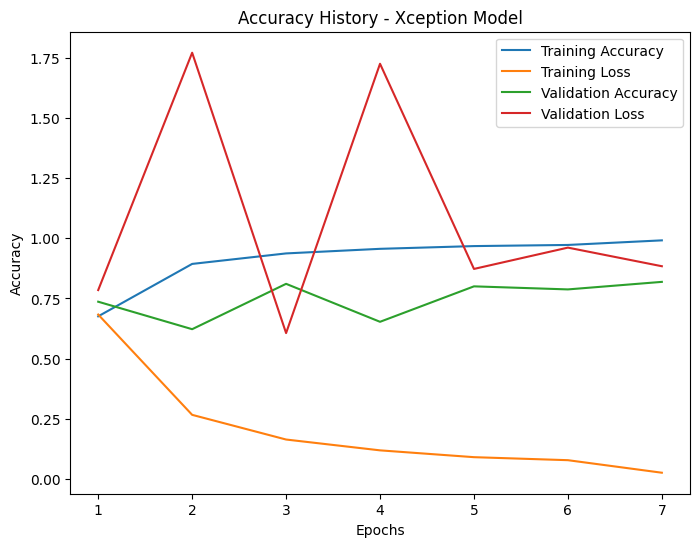

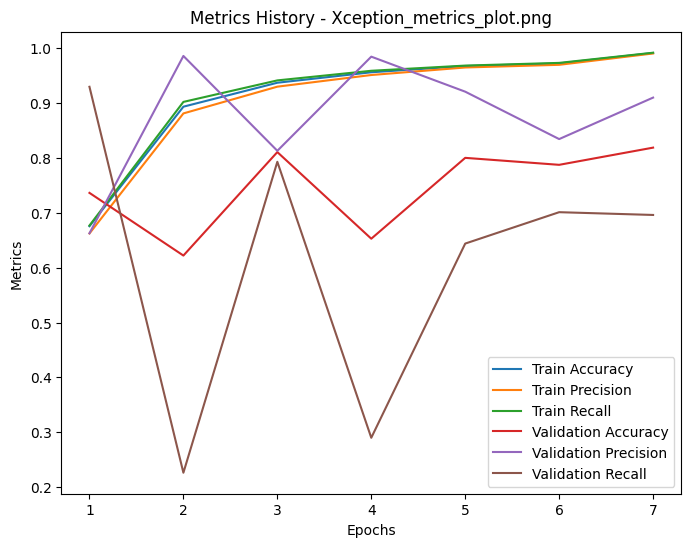

In [21]:
# Experiment ID:TMC-0011 - Xception 
experimentId = "TMC-0011"

# Load Directories (Leave alone unless specifying a different dataset)
experiment_train_directory = train_directory
experiment_test_directory = test_directory
experiment_directory = f"{experiment_base_directory}/{experimentId}"
experiment_results_directory = f"{experiment_directory}/results"
experiment_models_directory = f"{experiment_directory}/models"

# Create directories if they don't exist
os.makedirs(name=experiment_directory, exist_ok=True)
os.makedirs(name=experiment_models_directory, exist_ok=True)
os.makedirs(name=experiment_results_directory, exist_ok=True)

# Declare lists for report generation
accuracy_report = []

# Declare Test Configurations
test_configurations = [
    [Xception, xception_preprocess_input]
]

# Define Early Stopping Callback
# Define callbacks
early_stopping = EarlyStopping(
    monitor='val_loss', 
    mode='min', 
    verbose=1, 
    patience=4
)

lr_reducer = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.25,
    patience=3,
    verbose=1,
)

model_checkpoint_accuracy = ModelCheckpoint(
    filepath=f"{experiment_models_directory}/model_highest_accuracy.h5",
    monitor="val_binary_accuracy",
    save_best_only=True,
    verbose=1, 
)

model_checkpoint_loss = ModelCheckpoint(
    filepath=f"{experiment_models_directory}/model_lowest_loss.h5",
    monitor="val_loss",
    save_best_only=True,
    verbose=1, 
)

callbacks = [early_stopping, lr_reducer, model_checkpoint_accuracy, model_checkpoint_loss]

# Loop through all combinations of models and trainable layers
for pretrained_model, preprocessing_function in test_configurations:
    K.clear_session()
    
    # Create a dataset and preprocess images to suit base model
    train_ds, val_ds = create_train_val_datasets(preprocessing_function, experiment_train_directory, batch_size=64, augment_data=False)
    test_ds = create_test_dataset(preprocessing_function, experiment_test_directory, batch_size=64)

    # Create Input Layer
    inputs = Input(shape=(299, 299, 3))

    # Create the base model from the pre-trained model
    base_model = pretrained_model(
        weights="imagenet", 
        include_top=False,
        input_tensor=inputs)

    # Make Base Model Trainable
    base_model.trainable = True
    
    # Freeze the base model (do not train everything but last 23 layers)
    for layer in base_model.layers[:-23]:
        layer.trainable = False
    
    # Add a classification head
    top_model = base_model.output
    top_model = Conv2D(1024, (3, 3), padding='same')(top_model)
    top_model = BatchNormalization()(top_model)
    top_model = Activation('relu')(top_model)
    top_model = MaxPooling2D(pool_size=(2, 2))(top_model)
    top_model = Dropout(0.5)(top_model)

    top_model = Conv2D(1024, (3, 3), padding='same')(top_model)
    top_model = BatchNormalization()(top_model)
    top_model = Activation('relu')(top_model)
    top_model = MaxPooling2D(pool_size=(2, 2))(top_model)
    top_model = Dropout(0.5)(top_model)

    top_model = GlobalAveragePooling2D()(top_model)
    top_model = Dense(1024, activation='relu')(top_model)
    top_model = BatchNormalization()(top_model)
    top_model = Dropout(0.5)(top_model)

    top_model = Dense(1024, activation='relu')(top_model)
    top_model = BatchNormalization()(top_model)
    top_model = Dropout(0.5)(top_model)

    top_model = Dense(1, activation='sigmoid')(top_model)

    model = Model(inputs=base_model.input, outputs=top_model)
    
    # Compile the model
    model.compile(
        optimizer=Adam(.01),  
        loss=BinaryCrossentropy(from_logits=False),
        metrics=[BinaryAccuracy(), Precision(), Recall(), AUC()]
    )
    
    # Create Model Image
    create_model_image(model, experiment_models_directory, name = f'{pretrained_model.__name__}_model', extension = 'png')
    
    # Start Timer to measure processing time 
    start_time = time.time()

    # Train the model but first clear history (Required to append results without errors)
    history = model.fit(
        train_ds, 
        steps_per_epoch=train_ds.samples // train_ds.batch_size,
        epochs=50, 
        validation_data=val_ds,
        validation_steps=val_ds.samples // val_ds.batch_size,
        callbacks = callbacks
    )
    
    # End Timer and calculate processing time
    end_time = time.time()
    processing_time = end_time - start_time

    # Evaluate the model
    evaluate = model.evaluate(test_ds, steps = test_ds.samples // test_ds.batch_size, verbose=1)
    
    # Append results to accuracy_test list
    history_key = list(history.history.keys()) # As names of metric names can be dynamic, we need to get the keys of the history object
    accuracy_report.append({
        'Base Model': pretrained_model.__name__,
        'duration': round(processing_time, 3),
        'test_accuracy': round(evaluate[1], 3),
        'test_precision': round(evaluate[2], 3),
        'test_recall': round(evaluate[3], 3),
        'test_loss': round(evaluate[0], 3),
        'train_accuracy': round(history.history[history_key[1]][-1],3),
        'train_precision': round(history.history[history_key[2]][-1],3),
        'train_recall': round(history.history[history_key[3]][-1],3),
        'train_auc' : round(history.history[history_key[4]][-1],3),
        'train_loss': round(history.history[history_key[0]][-1],3),
        'val_accuracy': round(history.history[history_key[6]][-1],3),
        'val_precision': round(history.history[history_key[7]][-1],3),
        'val_recall': round(history.history[history_key[8]][-1],3),
        'val_auc' : round(history.history[history_key[9]][-1],3),
        'val_loss': round(history.history[history_key[5]][-1],3)
    })
    
    epochs_report = pd.DataFrame(history.history)
    epochs_report.to_csv(f"{experiment_results_directory}/{pretrained_model.__name__}_epochs_report.csv", index=False)

# Create DataFrame with accuracy score and export as .csv
accuracy_test_results = pd.DataFrame(accuracy_report)
accuracy_test_results.to_csv(f'{experiment_results_directory}/accuracy_test_results.csv', index=False)

# Generate graphs from epochs_reports.csv and output to results folder.
create_accuracy_plots(f"{experiment_results_directory}")
create_all_metrics_plots(f"{experiment_results_directory}")

Found 38634 images belonging to 2 classes.
Found 9657 images belonging to 2 classes.
Found 8557 images belonging to 2 classes.


2023-05-28 10:37:54.543102: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-05-28 10:37:54.543481: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-05-28 10:37:54.543809: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Epoch 1/50


2023-05-28 10:37:56.733528: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-05-28 10:38:00.176713: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2023-05-28 10:38:03.063105: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-05-28 10:38:03.073302: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x56451861ecf0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-05-28 10:38:03.073320: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA GeForce RTX 3070, Compute Capability 8.6
2023-05-28 10:38:03.07665

1207/1207 [==============================] - ETA: 0s - loss: 0.7102 - binary_accuracy: 0.5673 - precision: 0.5568 - recall: 0.5317 - auc: 0.6080

2023-05-28 10:41:07.030841: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-05-28 10:41:08.264561: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.83GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-05-28 10:41:08.274453: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.83GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.



Epoch 1: val_binary_accuracy improved from -inf to 0.77834, saving model to ../experiments/top-model-configuration/TMC-0012/models/model_highest_accuracy.h5

Epoch 1: val_loss improved from inf to 0.49632, saving model to ../experiments/top-model-configuration/TMC-0012/models/model_lowest_loss.h5
1207/1207 [==============================] - 219s 172ms/step - loss: 0.7102 - binary_accuracy: 0.5673 - precision: 0.5568 - recall: 0.5317 - auc: 0.6080 - val_loss: 0.4963 - val_binary_accuracy: 0.7783 - val_precision: 0.7227 - val_recall: 0.8825 - val_auc: 0.8718 - lr: 0.0010
Epoch 2/50
1207/1207 [==============================] - ETA: 0s - loss: 0.2395 - binary_accuracy: 0.9022 - precision: 0.8942 - recall: 0.9056 - auc: 0.9649
Epoch 2: val_binary_accuracy improved from 0.77834 to 0.82236, saving model to ../experiments/top-model-configuration/TMC-0012/models/model_highest_accuracy.h5

Epoch 2: val_loss improved from 0.49632 to 0.45034, saving model to ../experiments/top-model-configuration

2023-05-28 11:01:52.395710: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


267/267 [==============================] - 24s 88ms/step - loss: 0.4046 - binary_accuracy: 0.8965 - precision: 0.9047 - recall: 0.8799 - auc: 0.9501


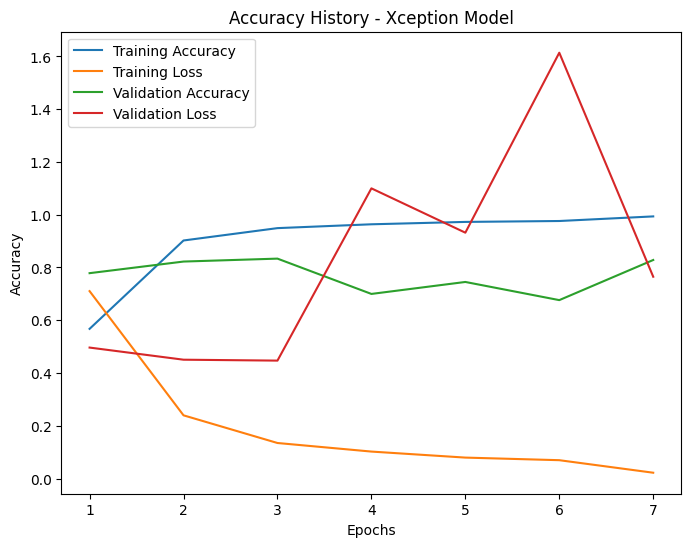

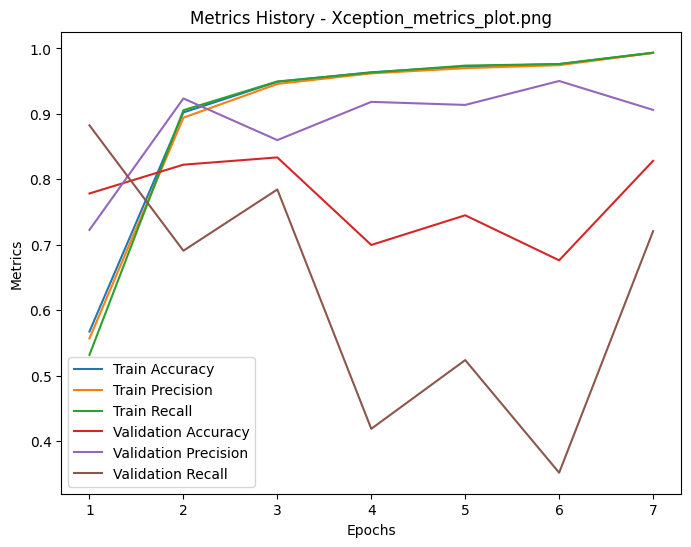

In [5]:
# Experiment ID:TMC-0012 - Xception 
experimentId = "TMC-0012"

# Load Directories (Leave alone unless specifying a different dataset)
experiment_train_directory = train_directory
experiment_test_directory = test_directory
experiment_directory = f"{experiment_base_directory}/{experimentId}"
experiment_results_directory = f"{experiment_directory}/results"
experiment_models_directory = f"{experiment_directory}/models"

# Create directories if they don't exist
os.makedirs(name=experiment_directory, exist_ok=True)
os.makedirs(name=experiment_models_directory, exist_ok=True)
os.makedirs(name=experiment_results_directory, exist_ok=True)

# Declare lists for report generation
accuracy_report = []

# Declare Test Configurations
test_configurations = [
    [Xception, xception_preprocess_input]
]

# Define Early Stopping Callback
# Define callbacks
early_stopping = EarlyStopping(
    monitor='val_loss', 
    mode='min', 
    verbose=1, 
    patience=4
)

lr_reducer = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.25,
    patience=3,
    verbose=1,
)

model_checkpoint_accuracy = ModelCheckpoint(
    filepath=f"{experiment_models_directory}/model_highest_accuracy.h5",
    monitor="val_binary_accuracy",
    save_best_only=True,
    verbose=1, 
)

model_checkpoint_loss = ModelCheckpoint(
    filepath=f"{experiment_models_directory}/model_lowest_loss.h5",
    monitor="val_loss",
    save_best_only=True,
    verbose=1, 
)

callbacks = [early_stopping, lr_reducer, model_checkpoint_accuracy, model_checkpoint_loss]

# Loop through all combinations of models and trainable layers
for pretrained_model, preprocessing_function in test_configurations:
    K.clear_session()
    
    # Create a dataset and preprocess images to suit base model
    train_ds, val_ds = create_train_val_datasets(preprocessing_function, experiment_train_directory, batch_size=32, augment_data=False)
    test_ds = create_test_dataset(preprocessing_function, experiment_test_directory, batch_size=32)

    # Create Input Layer
    inputs = Input(shape=(299, 299, 3))

    # Create the base model from the pre-trained model
    base_model = pretrained_model(
        weights="imagenet", 
        include_top=False,
        input_tensor=inputs)

    # Make Base Model Trainable
    base_model.trainable = True
    
    # Freeze the base model (do not train everything but last 23 layers)
    for layer in base_model.layers[:-23]:
        layer.trainable = False
    
    # Add a classification head
    top_model = base_model.output
    top_model = Conv2D(1024, (3, 3), padding='same')(top_model)
    top_model = BatchNormalization()(top_model)
    top_model = Activation('relu')(top_model)
    top_model = MaxPooling2D(pool_size=(2, 2))(top_model)

    top_model = Conv2D(1024, (3, 3), padding='same')(top_model)
    top_model = BatchNormalization()(top_model)
    top_model = Activation('relu')(top_model)
    top_model = MaxPooling2D(pool_size=(2, 2))(top_model)

    top_model = GlobalAveragePooling2D()(top_model)
    top_model = Dense(1024, activation='relu')(top_model)
    top_model = BatchNormalization()(top_model)
    top_model = Dropout(0.5)(top_model)

    top_model = Dense(1024, activation='relu')(top_model)
    top_model = BatchNormalization()(top_model)
    top_model = Dropout(0.5)(top_model)
    
    top_model = Dense(512, activation='relu')(top_model)
    top_model = BatchNormalization()(top_model)
    top_model = Dropout(0.5)(top_model)

    top_model = Dense(1, activation='sigmoid')(top_model)

    model = Model(inputs=base_model.input, outputs=top_model)
    
    # Compile the model
    model.compile(
        optimizer=Adam(1e-3),  
        loss=BinaryCrossentropy(from_logits=False),
        metrics=[BinaryAccuracy(), Precision(), Recall(), AUC()]
    )
    
    # Create Model Image
    create_model_image(model, experiment_models_directory, name = f'{pretrained_model.__name__}_model', extension = 'png')
    
    # Start Timer to measure processing time 
    start_time = time.time()

    # Train the model but first clear history (Required to append results without errors)
    history = model.fit(
        train_ds, 
        steps_per_epoch=train_ds.samples // train_ds.batch_size,
        epochs=50, 
        validation_data=val_ds,
        validation_steps=val_ds.samples // val_ds.batch_size,
        callbacks = callbacks
    )
    
    # End Timer and calculate processing time
    end_time = time.time()
    processing_time = end_time - start_time

    # Evaluate the model
    evaluate = model.evaluate(test_ds, steps = test_ds.samples // test_ds.batch_size, verbose=1)
    
    # Append results to accuracy_test list
    history_key = list(history.history.keys()) # As names of metric names can be dynamic, we need to get the keys of the history object
    accuracy_report.append({
        'Base Model': pretrained_model.__name__,
        'duration': round(processing_time, 3),
        'test_accuracy': round(evaluate[1], 3),
        'test_precision': round(evaluate[2], 3),
        'test_recall': round(evaluate[3], 3),
        'test_loss': round(evaluate[0], 3),
        'train_accuracy': round(history.history[history_key[1]][-1],3),
        'train_precision': round(history.history[history_key[2]][-1],3),
        'train_recall': round(history.history[history_key[3]][-1],3),
        'train_auc' : round(history.history[history_key[4]][-1],3),
        'train_loss': round(history.history[history_key[0]][-1],3),
        'val_accuracy': round(history.history[history_key[6]][-1],3),
        'val_precision': round(history.history[history_key[7]][-1],3),
        'val_recall': round(history.history[history_key[8]][-1],3),
        'val_auc' : round(history.history[history_key[9]][-1],3),
        'val_loss': round(history.history[history_key[5]][-1],3)
    })
    
    epochs_report = pd.DataFrame(history.history)
    epochs_report.to_csv(f"{experiment_results_directory}/{pretrained_model.__name__}_epochs_report.csv", index=False)

# Create DataFrame with accuracy score and export as .csv
accuracy_test_results = pd.DataFrame(accuracy_report)
accuracy_test_results.to_csv(f'{experiment_results_directory}/accuracy_test_results.csv', index=False)

# Generate graphs from epochs_reports.csv and output to results folder.
create_accuracy_plots(f"{experiment_results_directory}")
create_all_metrics_plots(f"{experiment_results_directory}")

Found 193164 images belonging to 2 classes.
Found 48290 images belonging to 2 classes.
Found 42786 images belonging to 2 classes.
Epoch 1/50


2023-05-28 15:01:24.329761: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


6036/6036 [==============================] - ETA: 0s - loss: 0.2300 - binary_accuracy: 0.8968 - precision: 0.8917 - recall: 0.8963 - auc: 0.9680

2023-05-28 15:15:30.131872: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]



Epoch 1: val_binary_accuracy improved from -inf to 0.82664, saving model to ../experiments/top-model-configuration/TMC-0012/models/model_highest_accuracy.h5

Epoch 1: val_loss improved from inf to 0.56864, saving model to ../experiments/top-model-configuration/TMC-0012/models/model_lowest_loss.h5
6036/6036 [==============================] - 987s 163ms/step - loss: 0.2300 - binary_accuracy: 0.8968 - precision: 0.8917 - recall: 0.8963 - auc: 0.9680 - val_loss: 0.5686 - val_binary_accuracy: 0.8266 - val_precision: 0.7738 - val_recall: 0.9084 - val_auc: 0.9116 - lr: 0.0010
Epoch 2/50
6036/6036 [==============================] - ETA: 0s - loss: 0.0726 - binary_accuracy: 0.9744 - precision: 0.9721 - recall: 0.9752 - auc: 0.9960
Epoch 2: val_binary_accuracy did not improve from 0.82664

Epoch 2: val_loss did not improve from 0.56864
6036/6036 [==============================] - 1023s 170ms/step - loss: 0.0726 - binary_accuracy: 0.9744 - precision: 0.9721 - recall: 0.9752 - auc: 0.9960 - val_l

2023-05-28 16:25:59.152430: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


1337/1337 [==============================] - 127s 95ms/step - loss: 0.4995 - binary_accuracy: 0.8972 - precision: 0.8941 - recall: 0.8943 - auc: 0.9444


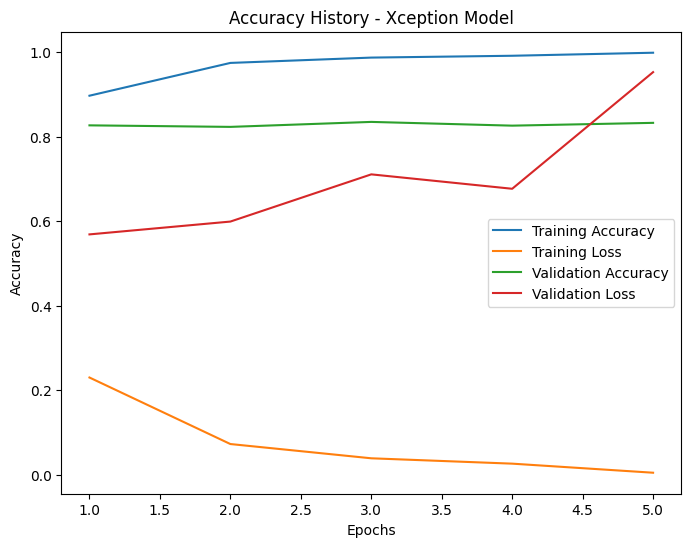

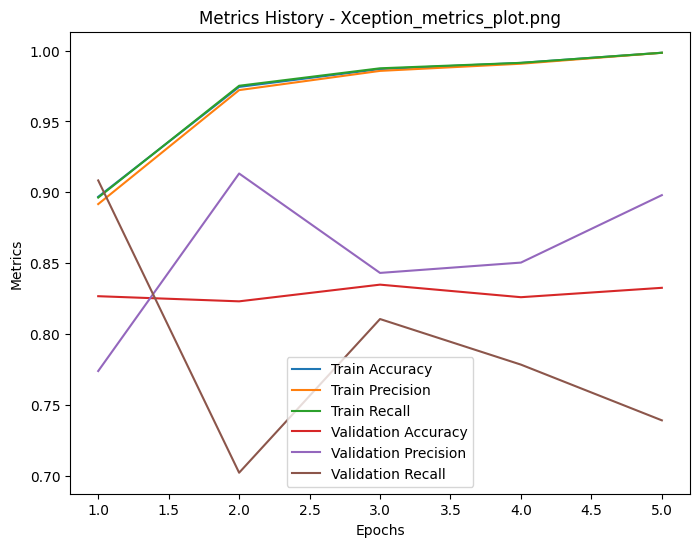

In [16]:
# Experiment ID:TMC-0012 - Xception 
experimentId = "TMC-0012"

# Load Directories (Leave alone unless specifying a different dataset)
experiment_train_directory = "/media/luke/System Storage/Deepfake Dataset/FF++/combine/train"
experiment_test_directory = "/media/luke/System Storage/Deepfake Dataset/FF++/combine/test"
experiment_directory = f"{experiment_base_directory}/{experimentId}"
experiment_results_directory = f"{experiment_directory}/results"
experiment_models_directory = f"{experiment_directory}/models"

# Create directories if they don't exist
os.makedirs(name=experiment_directory, exist_ok=True)
os.makedirs(name=experiment_models_directory, exist_ok=True)
os.makedirs(name=experiment_results_directory, exist_ok=True)

# Declare lists for report generation
accuracy_report = []

# Declare Test Configurations
test_configurations = [
    [Xception, xception_preprocess_input]
]

# Define Early Stopping Callback
# Define callbacks
early_stopping = EarlyStopping(
    monitor='val_loss', 
    mode='min', 
    verbose=1, 
    patience=4
)

lr_reducer = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.25,
    patience=3,
    verbose=1,
)

model_checkpoint_accuracy = ModelCheckpoint(
    filepath=f"{experiment_models_directory}/model_highest_accuracy.h5",
    monitor="val_binary_accuracy",
    save_best_only=True,
    verbose=1, 
)

model_checkpoint_loss = ModelCheckpoint(
    filepath=f"{experiment_models_directory}/model_lowest_loss.h5",
    monitor="val_loss",
    save_best_only=True,
    verbose=1, 
)

callbacks = [early_stopping, lr_reducer, model_checkpoint_accuracy, model_checkpoint_loss]

# Loop through all combinations of models and trainable layers
for pretrained_model, preprocessing_function in test_configurations:
    K.clear_session()
    
    # Create a dataset and preprocess images to suit base model
    train_ds, val_ds = create_train_val_datasets(preprocessing_function, experiment_train_directory, batch_size=32, augment_data=False)
    test_ds = create_test_dataset(preprocessing_function, experiment_test_directory, batch_size=32)

    # Create Input Layer
    inputs = Input(shape=(299, 299, 3))

    # Create the base model from the pre-trained model
    base_model = pretrained_model(
        weights="imagenet", 
        include_top=False,
        input_tensor=inputs)

    # Make Base Model Trainable
    base_model.trainable = True
    
    # Freeze the base model (do not train everything but last 23 layers)
    for layer in base_model.layers[:-23]:
        layer.trainable = False
    
    # Add a classification head
    top_model = base_model.output
    top_model = Conv2D(1024, (3, 3), padding='same')(top_model)
    top_model = BatchNormalization()(top_model)
    top_model = Activation('relu')(top_model)
    top_model = MaxPooling2D(pool_size=(2, 2))(top_model)

    top_model = Conv2D(1024, (3, 3), padding='same')(top_model)
    top_model = BatchNormalization()(top_model)
    top_model = Activation('relu')(top_model)
    top_model = MaxPooling2D(pool_size=(2, 2))(top_model)

    top_model = GlobalAveragePooling2D()(top_model)
    top_model = Dense(1024, activation='relu')(top_model)
    top_model = BatchNormalization()(top_model)
    top_model = Dropout(0.5)(top_model)

    top_model = Dense(1024, activation='relu')(top_model)
    top_model = BatchNormalization()(top_model)
    top_model = Dropout(0.5)(top_model)
    
    top_model = Dense(512, activation='relu')(top_model)
    top_model = BatchNormalization()(top_model)
    top_model = Dropout(0.5)(top_model)

    top_model = Dense(1, activation='sigmoid')(top_model)

    model = Model(inputs=base_model.input, outputs=top_model)
    
    # Compile the model
    model.compile(
        optimizer=Adam(1e-3),  
        loss=BinaryCrossentropy(from_logits=False),
        metrics=[BinaryAccuracy(), Precision(), Recall(), AUC()]
    )
    
    # Create Model Image
    create_model_image(model, experiment_models_directory, name = f'{pretrained_model.__name__}_model', extension = 'png')
    
    # Start Timer to measure processing time 
    start_time = time.time()

    # Train the model but first clear history (Required to append results without errors)
    history = model.fit(
        train_ds, 
        steps_per_epoch=train_ds.samples // train_ds.batch_size,
        epochs=50, 
        validation_data=val_ds,
        validation_steps=val_ds.samples // val_ds.batch_size,
        callbacks = callbacks
    )
    
    # End Timer and calculate processing time
    end_time = time.time()
    processing_time = end_time - start_time

    # Evaluate the model
    evaluate = model.evaluate(test_ds, steps = test_ds.samples // test_ds.batch_size, verbose=1)
    
    # Append results to accuracy_test list
    history_key = list(history.history.keys()) # As names of metric names can be dynamic, we need to get the keys of the history object
    accuracy_report.append({
        'Base Model': pretrained_model.__name__,
        'duration': round(processing_time, 3),
        'test_accuracy': round(evaluate[1], 3),
        'test_precision': round(evaluate[2], 3),
        'test_recall': round(evaluate[3], 3),
        'test_loss': round(evaluate[0], 3),
        'train_accuracy': round(history.history[history_key[1]][-1],3),
        'train_precision': round(history.history[history_key[2]][-1],3),
        'train_recall': round(history.history[history_key[3]][-1],3),
        'train_auc' : round(history.history[history_key[4]][-1],3),
        'train_loss': round(history.history[history_key[0]][-1],3),
        'val_accuracy': round(history.history[history_key[6]][-1],3),
        'val_precision': round(history.history[history_key[7]][-1],3),
        'val_recall': round(history.history[history_key[8]][-1],3),
        'val_auc' : round(history.history[history_key[9]][-1],3),
        'val_loss': round(history.history[history_key[5]][-1],3)
    })
    
    epochs_report = pd.DataFrame(history.history)
    epochs_report.to_csv(f"{experiment_results_directory}/{pretrained_model.__name__}_epochs_report.csv", index=False)

# Create DataFrame with accuracy score and export as .csv
accuracy_test_results = pd.DataFrame(accuracy_report)
accuracy_test_results.to_csv(f'{experiment_results_directory}/accuracy_test_results.csv', index=False)

# Generate graphs from epochs_reports.csv and output to results folder.
create_accuracy_plots(f"{experiment_results_directory}")
create_all_metrics_plots(f"{experiment_results_directory}")

Found 12074 images belonging to 2 classes.
Found 2414 images belonging to 2 classes.
Found 4279 images belonging to 2 classes.
Epoch 1/50


2023-05-28 17:46:16.840790: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


377/377 [==============================] - ETA: 0s - loss: 1.1125 - binary_accuracy: 0.5089 - precision: 0.4940 - recall: 0.4906 - auc: 0.5120

2023-05-28 17:48:38.056093: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]



Epoch 1: val_binary_accuracy improved from -inf to 0.52458, saving model to ../experiments/top-model-configuration/TMC-0013/models/model_highest_accuracy.h5

Epoch 1: val_loss improved from inf to 0.68442, saving model to ../experiments/top-model-configuration/TMC-0013/models/model_lowest_loss.h5
377/377 [==============================] - 150s 390ms/step - loss: 1.1125 - binary_accuracy: 0.5089 - precision: 0.4940 - recall: 0.4906 - auc: 0.5120 - val_loss: 0.6844 - val_binary_accuracy: 0.5246 - val_precision: 0.5086 - val_recall: 0.6598 - val_auc: 0.5748 - lr: 0.0010
Epoch 2/50
377/377 [==============================] - ETA: 0s - loss: 0.7473 - binary_accuracy: 0.5619 - precision: 0.5506 - recall: 0.5301 - auc: 0.5865
Epoch 2: val_binary_accuracy improved from 0.52458 to 0.68083, saving model to ../experiments/top-model-configuration/TMC-0013/models/model_highest_accuracy.h5

Epoch 2: val_loss improved from 0.68442 to 0.59832, saving model to ../experiments/top-model-configuration/TMC

2023-05-28 19:47:31.512908: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


133/133 [==============================] - 12s 89ms/step - loss: 0.8032 - binary_accuracy: 0.7206 - precision: 0.7247 - recall: 0.6851 - auc: 0.7891


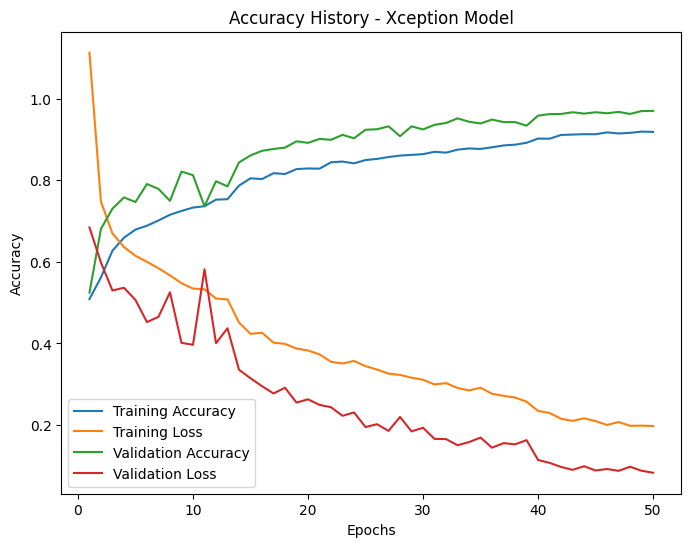

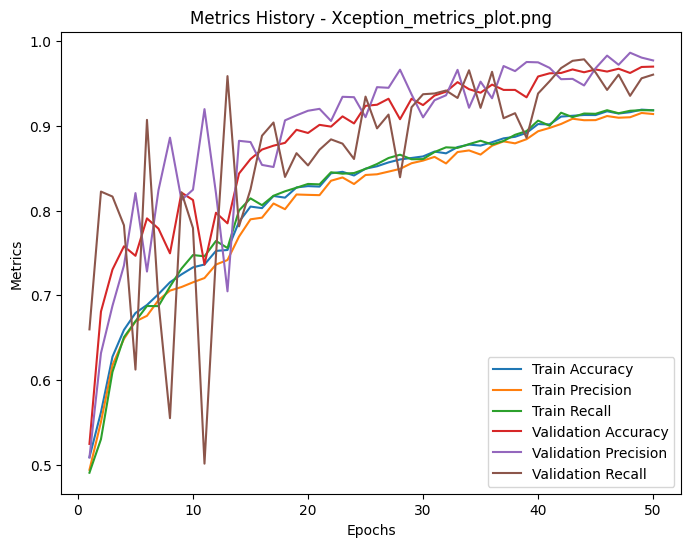

In [30]:
# Experiment ID:TMC-0013 - Xception 
experimentId = "TMC-0013"

# Load Directories (Leave alone unless specifying a different dataset)
experiment_train_directory = train_directory
experiment_test_directory = test_directory
experiment_directory = f"{experiment_base_directory}/{experimentId}"
experiment_results_directory = f"{experiment_directory}/results"
experiment_models_directory = f"{experiment_directory}/models"

# Create directories if they don't exist
os.makedirs(name=experiment_directory, exist_ok=True)
os.makedirs(name=experiment_models_directory, exist_ok=True)
os.makedirs(name=experiment_results_directory, exist_ok=True)

# Declare lists for report generation
accuracy_report = []

# Declare Test Configurations
test_configurations = [
    [Xception, xception_preprocess_input]
]

# Define Early Stopping Callback
# Define callbacks
early_stopping = EarlyStopping(
    monitor='val_loss', 
    mode='min', 
    verbose=1, 
    patience=4
)

lr_reducer = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.25,
    patience=3,
    verbose=1,
)

model_checkpoint_accuracy = ModelCheckpoint(
    filepath=f"{experiment_models_directory}/model_highest_accuracy.h5",
    monitor="val_binary_accuracy",
    save_best_only=True,
    verbose=1, 
)

model_checkpoint_loss = ModelCheckpoint(
    filepath=f"{experiment_models_directory}/model_lowest_loss.h5",
    monitor="val_loss",
    save_best_only=True,
    verbose=1, 
)

callbacks = [early_stopping, lr_reducer, model_checkpoint_accuracy, model_checkpoint_loss]

# Loop through all combinations of models and trainable layers
for pretrained_model, preprocessing_function in test_configurations:
    K.clear_session()
    
    # Create a dataset and preprocess images to suit base model
    train_ds, val_ds = create_train_val_datasets(preprocessing_function, experiment_train_directory, batch_size=32, augment_data=True)
    test_ds = create_test_dataset(preprocessing_function, experiment_test_directory, batch_size=32)

    # Create Input Layer
    inputs = Input(shape=(299, 299, 3))

    # Create the base model from the pre-trained model
    base_model = pretrained_model(
        weights="imagenet", 
        include_top=False,
        input_tensor=inputs)

    # Make Base Model Trainable
    base_model.trainable = False
    
    # Freeze the base model (do not train everything but last 23 layers)
    for layer in base_model.layers[:-23]:
        layer.trainable = False
    
    # Add a classification head
    top_model = base_model(inputs, training=False)
    top_model = Conv2D(1024, (3, 3), padding='same')(top_model)
    top_model = BatchNormalization()(top_model)
    top_model = Activation('relu')(top_model)
    top_model = MaxPooling2D(pool_size=(2, 2))(top_model)

    top_model = Conv2D(1024, (3, 3), padding='same')(top_model)
    top_model = BatchNormalization()(top_model)
    top_model = Activation('relu')(top_model)
    top_model = MaxPooling2D(pool_size=(2, 2))(top_model)

    top_model = GlobalAveragePooling2D()(top_model)
    top_model = Dense(1024, activation='relu')(top_model)
    top_model = BatchNormalization()(top_model)
    top_model = Dropout(0.8)(top_model)

    top_model = Dense(1024, activation='relu')(top_model)
    top_model = BatchNormalization()(top_model)
    top_model = Dropout(0.8)(top_model)

    top_model = Dense(1, activation='sigmoid')(top_model)

    model = Model(inputs=base_model.input, outputs=top_model)
    
    # Compile the model
    model.compile(
        optimizer=Adam(1e-3),  
        loss=BinaryCrossentropy(from_logits=False),
        metrics=[BinaryAccuracy(), Precision(), Recall(), AUC()]
    )
    
    # Create Model Image
    create_model_image(model, experiment_models_directory, name = f'{pretrained_model.__name__}_model', extension = 'png')
    
    # Start Timer to measure processing time 
    start_time = time.time()

    # Train the model but first clear history (Required to append results without errors)
    history = model.fit(
        train_ds, 
        steps_per_epoch=train_ds.samples // train_ds.batch_size,
        epochs=50, 
        validation_data=val_ds,
        validation_steps=val_ds.samples // val_ds.batch_size,
        callbacks = callbacks
    )
    
    # End Timer and calculate processing time
    end_time = time.time()
    processing_time = end_time - start_time

    # Evaluate the model
    evaluate = model.evaluate(test_ds, steps = test_ds.samples // test_ds.batch_size, verbose=1)
    
    # Save Model & Weights
    model.save(f"{experiment_models_directory}/final_model.h5")
    model.save_weights(f"{experiment_models_directory}/final_model_weights.h5")
    
    # Append results to accuracy_test list
    history_key = list(history.history.keys()) # As names of metric names can be dynamic, we need to get the keys of the history object
    accuracy_report.append({
        'Base Model': pretrained_model.__name__,
        'duration': round(processing_time, 3),
        'test_accuracy': round(evaluate[1], 3),
        'test_precision': round(evaluate[2], 3),
        'test_recall': round(evaluate[3], 3),
        'test_loss': round(evaluate[0], 3),
        'train_accuracy': round(history.history[history_key[1]][-1],3),
        'train_precision': round(history.history[history_key[2]][-1],3),
        'train_recall': round(history.history[history_key[3]][-1],3),
        'train_auc' : round(history.history[history_key[4]][-1],3),
        'train_loss': round(history.history[history_key[0]][-1],3),
        'val_accuracy': round(history.history[history_key[6]][-1],3),
        'val_precision': round(history.history[history_key[7]][-1],3),
        'val_recall': round(history.history[history_key[8]][-1],3),
        'val_auc' : round(history.history[history_key[9]][-1],3),
        'val_loss': round(history.history[history_key[5]][-1],3)
    })
    
    epochs_report = pd.DataFrame(history.history)
    epochs_report.to_csv(f"{experiment_results_directory}/{pretrained_model.__name__}_epochs_report.csv", index=False)

# Create DataFrame with accuracy score and export as .csv
accuracy_test_results = pd.DataFrame(accuracy_report)
accuracy_test_results.to_csv(f'{experiment_results_directory}/accuracy_test_results.csv', index=False)

# Generate graphs from epochs_reports.csv and output to results folder.
create_accuracy_plots(f"{experiment_results_directory}")
create_all_metrics_plots(f"{experiment_results_directory}")

In [31]:
base_model.summary()

Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 149, 149, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                          

In [32]:
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 299, 299, 3)]     0         
                                                                 
 xception (Functional)       (None, 10, 10, 2048)      20861480  
                                                                 
 conv2d_4 (Conv2D)           (None, 10, 10, 1024)      18875392  
                                                                 
 batch_normalization_4 (Batc  (None, 10, 10, 1024)     4096      
 hNormalization)                                                 
                                                                 
 activation (Activation)     (None, 10, 10, 1024)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 5, 5, 1024)       0         
 )                                                           

In [33]:
model.save(f"{experiment_models_directory}/final_model.h5")
model.save_weights(f"{experiment_models_directory}/final_model_weights.h5")

In [38]:
# Experiment ID:TMC-0013 - Xception 
experimentId = "TMC-0013"
finetuneVersion = "FT-1"

# Load Directories (Leave alone unless specifying a different dataset)
experiment_train_directory = train_directory
experiment_test_directory = test_directory
experiment_directory = f"{experiment_base_directory}/{experimentId}/{finetuneVersion}"
experiment_results_directory = f"{experiment_directory}/results"
experiment_models_directory = f"{experiment_directory}/models"

# Create directories if they don't exist
os.makedirs(name=experiment_directory, exist_ok=True)
os.makedirs(name=experiment_models_directory, exist_ok=True)
os.makedirs(name=experiment_results_directory, exist_ok=True)

# Declare lists for report generation
accuracy_report = []

# Declare Test Configurations
test_configurations = [
    [Xception, xception_preprocess_input]
]

# Define Early Stopping Callback
# Define callbacks
early_stopping = EarlyStopping(
    monitor='val_loss', 
    mode='min', 
    verbose=1, 
    patience=4
)

lr_reducer = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.25,
    patience=3,
    verbose=1,
)

model_checkpoint_accuracy = ModelCheckpoint(
    filepath=f"{experiment_models_directory}/model_highest_accuracy.h5",
    monitor="val_binary_accuracy",
    save_best_only=True,
    verbose=1, 
)

model_checkpoint_loss = ModelCheckpoint(
    filepath=f"{experiment_models_directory}/model_lowest_loss.h5",
    monitor="val_loss",
    save_best_only=True,
    verbose=1, 
)

callbacks = [early_stopping, lr_reducer, model_checkpoint_accuracy, model_checkpoint_loss]

# Loop through all combinations of models and trainable layers
for pretrained_model, preprocessing_function in test_configurations:
    K.clear_session()

    # Create a dataset and preprocess images to suit base model
    train_ds, val_ds = create_train_val_datasets(preprocessing_function, experiment_train_directory, batch_size=32, augment_data=True)
    test_ds = create_test_dataset(preprocessing_function, experiment_test_directory, batch_size=32)

    # Load Model
    model = keras.models.load_model(
        "../experiments/top-model-configuration/TMC-0013/models/final_model.h5"
    )
    
    # Create Input Layer
    inputs = Input(shape=(299, 299, 3))

    # Base model is the second layer in the model
    base_model = model.layers[1]

    # Make Base Model Trainable
    base_model.trainable = True

    # Freeze the base model (do not train everything but last 23 layers)
    for layer in base_model.layers[:-23]:
        layer.trainable = False

    # Everything after the base model is your top model
    # We need to hook up these layers correctly to the base model
    inputs = keras.Input(shape=(299, 299, 3))
    x = base_model(inputs, training=False)

    # Traverse the layers and connect them
    for layer in model.layers[2:]:
        x = layer(x)

    # Define the model
    model = keras.Model(inputs=inputs, outputs=x)

    # Compile the model
    model.compile(
        optimizer=Adam(1e-5),  
        loss=BinaryCrossentropy(from_logits=False),
        metrics=[BinaryAccuracy(), Precision(), Recall(), AUC()]
    )

    # Create Model Image
    create_model_image(model, experiment_models_directory, name = f'{pretrained_model.__name__}_model', extension = 'png')

    # Start Timer to measure processing time 
    start_time = time.time()

    # Train the model but first clear history (Required to append results without errors)
    history = model.fit(
        train_ds, 
        steps_per_epoch=train_ds.samples // train_ds.batch_size,
        epochs=50, 
        validation_data=val_ds,
        validation_steps=val_ds.samples // val_ds.batch_size,
        callbacks = callbacks
    )

    # End Timer and calculate processing time
    end_time = time.time()
    processing_time = end_time - start_time

    # Evaluate the model
    evaluate = model.evaluate(test_ds, steps = test_ds.samples // test_ds.batch_size, verbose=1)

    # Append results to accuracy_test list
    history_key = list(history.history.keys()) # As names of metric names can be dynamic, we need to get the keys of the history object
    accuracy_report.append({
        'Base Model': pretrained_model.__name__,
        'duration': round(processing_time, 3),
        'test_accuracy': round(evaluate[1], 3),
        'test_precision': round(evaluate[2], 3),
        'test_recall': round(evaluate[3], 3),
        'test_loss': round(evaluate[0], 3),
        'train_accuracy': round(history.history[history_key[1]][-1],3),
        'train_precision': round(history.history[history_key[2]][-1],3),
        'train_recall': round(history.history[history_key[3]][-1],3),
        'train_auc' : round(history.history[history_key[4]][-1],3),
        'train_loss': round(history.history[history_key[0]][-1],3),
        'val_accuracy': round(history.history[history_key[6]][-1],3),
        'val_precision': round(history.history[history_key[7]][-1],3),
        'val_recall': round(history.history[history_key[8]][-1],3),
        'val_auc' : round(history.history[history_key[9]][-1],3),
        'val_loss': round(history.history[history_key[5]][-1],3)
    })

    epochs_report = pd.DataFrame(history.history)
    epochs_report.to_csv(f"{experiment_results_directory}/{pretrained_model.__name__}_epochs_report.csv", index=False)

    model.save(f"{experiment_models_directory}/final_model_finetunned.h5")
    model.save_weights(f"{experiment_models_directory}/final_model_weights.h5")
    
# Create DataFrame with accuracy score and export as .csv
accuracy_test_results = pd.DataFrame(accuracy_report)
accuracy_test_results.to_csv(f'{experiment_results_directory}/accuracy_test_results.csv', index=False)

# Generate graphs from epochs_reports.csv and output to results folder.
create_accuracy_plots(f"{experiment_results_directory}")
create_all_metrics_plots(f"{experiment_results_directory}")

Found 12074 images belonging to 2 classes.
Found 2414 images belonging to 2 classes.
Found 4279 images belonging to 2 classes.
Epoch 1/50


2023-05-28 20:12:05.636415: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


377/377 [==============================] - ETA: 0s - loss: 0.2044 - binary_accuracy: 0.9170 - precision: 0.9100 - recall: 0.9201 - auc: 0.9744

2023-05-28 20:14:26.129698: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]



Epoch 1: val_binary_accuracy improved from -inf to 0.96250, saving model to ../experiments/top-model-configuration/TMC-0013/FT-1/models/model_highest_accuracy.h5

Epoch 1: val_loss improved from inf to 0.08944, saving model to ../experiments/top-model-configuration/TMC-0013/FT-1/models/model_lowest_loss.h5
377/377 [==============================] - 149s 383ms/step - loss: 0.2044 - binary_accuracy: 0.9170 - precision: 0.9100 - recall: 0.9201 - auc: 0.9744 - val_loss: 0.0894 - val_binary_accuracy: 0.9625 - val_precision: 0.9770 - val_recall: 0.9451 - val_auc: 0.9967 - lr: 1.0000e-05
Epoch 2/50
377/377 [==============================] - ETA: 0s - loss: 0.1928 - binary_accuracy: 0.9227 - precision: 0.9204 - recall: 0.9203 - auc: 0.9771
Epoch 2: val_binary_accuracy did not improve from 0.96250

Epoch 2: val_loss did not improve from 0.08944
377/377 [==============================] - 146s 387ms/step - loss: 0.1928 - binary_accuracy: 0.9227 - precision: 0.9204 - recall: 0.9203 - auc: 0.9771 

KeyboardInterrupt: 

Found 193164 images belonging to 2 classes.
Found 42786 images belonging to 2 classes.
Epoch 1/20


2023-05-28 23:59:41.729392: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


3018/3018 [==============================] - ETA: 0s - loss: 0.7138 - binary_accuracy: 0.6187 - precision: 0.6084 - recall: 0.6014 - auc: 0.6656

2023-05-29 00:37:05.868441: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]



Epoch 1: val_binary_accuracy improved from -inf to 0.66083, saving model to ../experiments/top-model-configuration/TMC-0014/models/model_highest_accuracy.h5

Epoch 1: val_loss improved from inf to 0.63593, saving model to ../experiments/top-model-configuration/TMC-0014/models/model_lowest_loss.h5
3018/3018 [==============================] - 2362s 782ms/step - loss: 0.7138 - binary_accuracy: 0.6187 - precision: 0.6084 - recall: 0.6014 - auc: 0.6656 - val_loss: 0.6359 - val_binary_accuracy: 0.6608 - val_precision: 0.6551 - val_recall: 0.6382 - val_auc: 0.7313 - lr: 0.0100
Epoch 2/20
3018/3018 [==============================] - ETA: 0s - loss: 0.4742 - binary_accuracy: 0.7768 - precision: 0.7647 - recall: 0.7802 - auc: 0.8562
Epoch 2: val_binary_accuracy improved from 0.66083 to 0.68423, saving model to ../experiments/top-model-configuration/TMC-0014/models/model_highest_accuracy.h5

Epoch 2: val_loss did not improve from 0.63593
3018/3018 [==============================] - 2356s 781ms/s

2023-05-29 03:15:44.300634: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


668/668 [==============================] - 117s 175ms/step - loss: 0.7981 - binary_accuracy: 0.7134 - precision: 0.7587 - recall: 0.6015 - auc: 0.7952


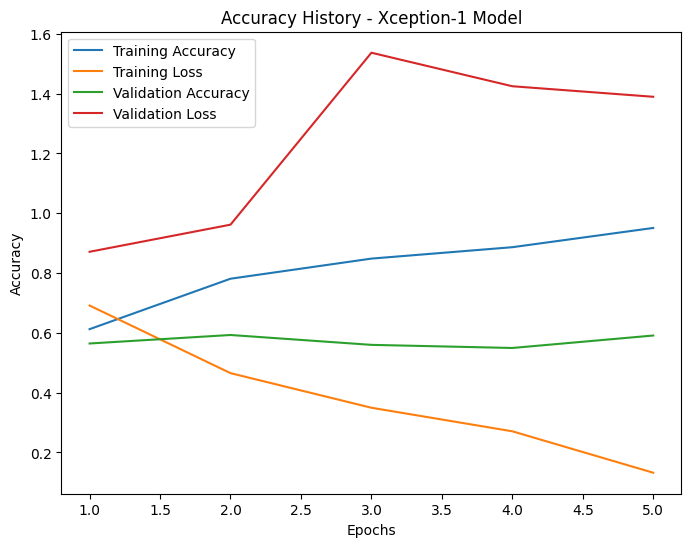

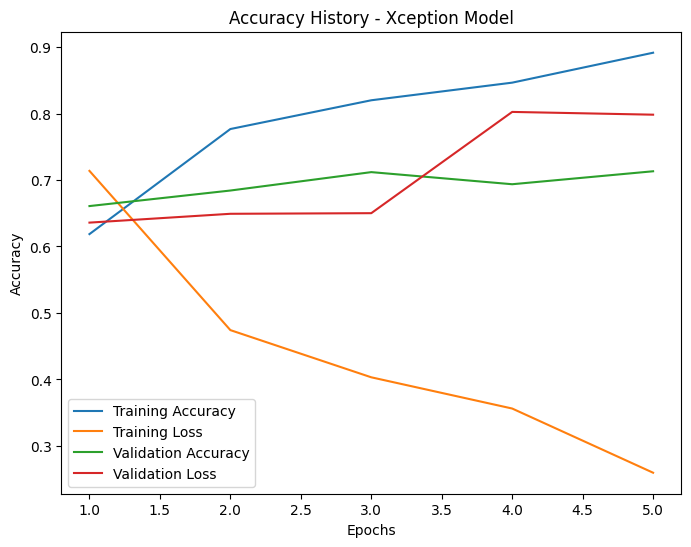

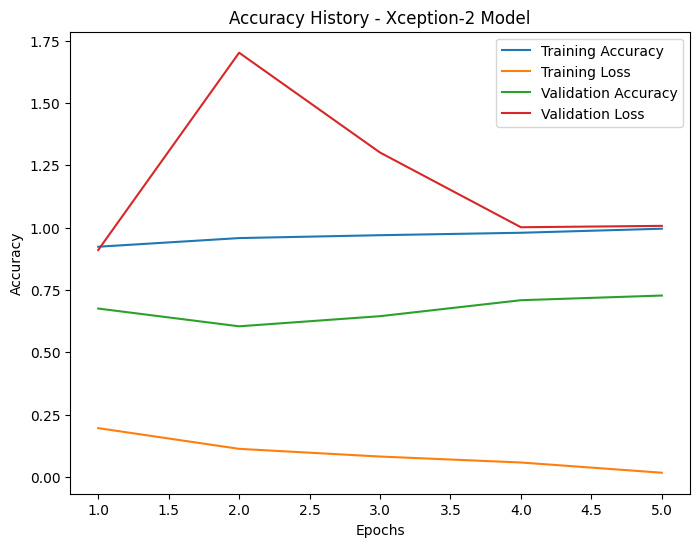

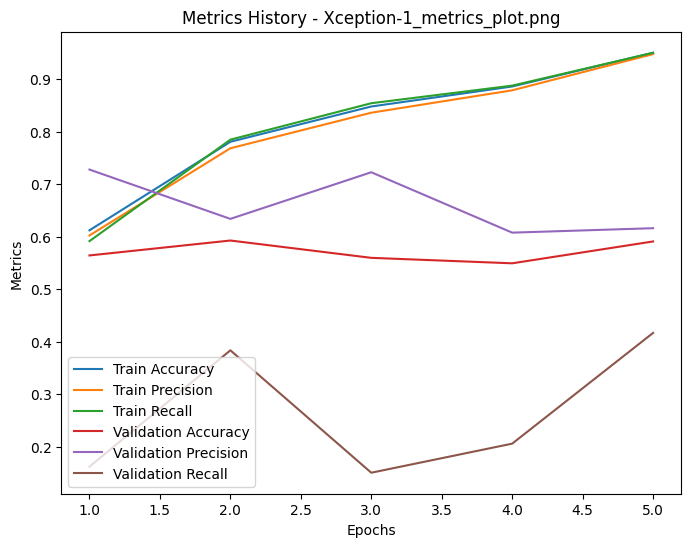

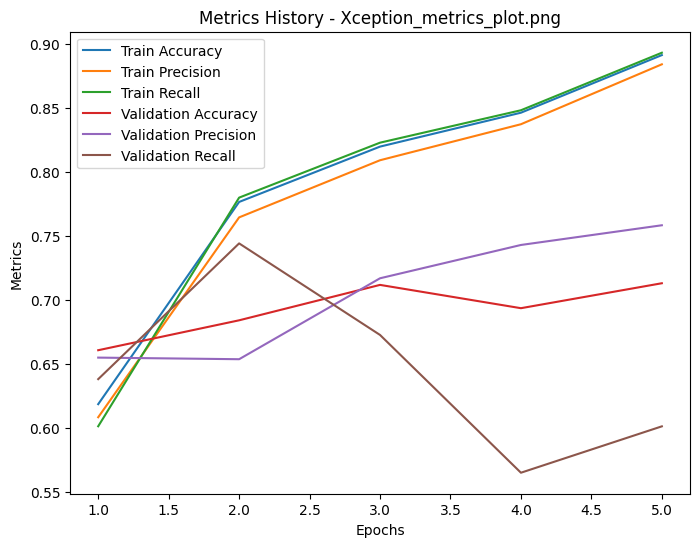

KeyError: 'precision'

In [50]:
# Experiment ID:TMC-0014 - Xception 
experimentId = "TMC-0014"

# Load Directories (Leave alone unless specifying a different dataset)
experiment_train_directory = "/media/luke/System Storage/Deepfake Dataset/FF++/combine/train"
experiment_test_directory = "/media/luke/System Storage/Deepfake Dataset/FF++/combine/test"
experiment_directory = f"{experiment_base_directory}/{experimentId}"
experiment_results_directory = f"{experiment_directory}/results"
experiment_models_directory = f"{experiment_directory}/models"

# Create directories if they don't exist
os.makedirs(name=experiment_directory, exist_ok=True)
os.makedirs(name=experiment_models_directory, exist_ok=True)
os.makedirs(name=experiment_results_directory, exist_ok=True)

# Declare lists for report generation
accuracy_report = []

# Declare Test Configurations
test_configurations = [
    [Xception, xception_preprocess_input]
]

# Define Early Stopping Callback
# Define callbacks
early_stopping = EarlyStopping(
    monitor='val_loss', 
    mode='min', 
    verbose=1, 
    patience=4
)

lr_reducer = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.25,
    patience=3,
    verbose=1,
)

model_checkpoint_accuracy = ModelCheckpoint(
    filepath=f"{experiment_models_directory}/model_highest_accuracy.h5",
    monitor="val_binary_accuracy",
    save_best_only=True,
    verbose=1, 
)

model_checkpoint_loss = ModelCheckpoint(
    filepath=f"{experiment_models_directory}/model_lowest_loss.h5",
    monitor="val_loss",
    save_best_only=True,
    verbose=1, 
)

callbacks = [early_stopping, lr_reducer, model_checkpoint_accuracy, model_checkpoint_loss]

# Loop through all combinations of models and trainable layers
for pretrained_model, preprocessing_function in test_configurations:
    K.clear_session()
    
    # Create a dataset and preprocess images to suit base model
    train_ds = create_train_dataset(preprocessing_function, experiment_train_directory, batch_size=64, augment_data=True)
    test_ds = create_test_dataset(preprocessing_function, experiment_test_directory, batch_size=64)

    # Create Input Layer
    inputs = Input(shape=(299, 299, 3))

    # Create the base model from the pre-trained model
    base_model = pretrained_model(
        weights="imagenet", 
        include_top=False,
        input_tensor=inputs)

    # Make Base Model Trainable
    base_model.trainable = False
    
    # Freeze the base model (do not train everything but last 23 layers)
    for layer in base_model.layers[:-23]:
        layer.trainable = False
    
    # Add a classification head
    top_model = base_model(inputs, training=False)
    top_model = Conv2D(1024, (3, 3), padding='same')(top_model)
    top_model = BatchNormalization()(top_model)
    top_model = Activation('relu')(top_model)
    top_model = MaxPooling2D(pool_size=(2, 2))(top_model)

    top_model = Conv2D(1024, (3, 3), padding='same')(top_model)
    top_model = BatchNormalization()(top_model)
    top_model = Activation('relu')(top_model)
    top_model = MaxPooling2D(pool_size=(2, 2))(top_model)

    top_model = GlobalAveragePooling2D()(top_model)
    top_model = Dense(1024, activation='relu')(top_model)
    top_model = BatchNormalization()(top_model)
    top_model = Dropout(0.8)(top_model)

    top_model = Dense(1024, activation='relu')(top_model)
    top_model = BatchNormalization()(top_model)
    top_model = Dropout(0.8)(top_model)

    top_model = Dense(1, activation='sigmoid')(top_model)

    model = Model(inputs=base_model.input, outputs=top_model)
    
    # Compile the model
    model.compile(
        optimizer=Adam(1e-2),  
        loss=BinaryCrossentropy(from_logits=False),
        metrics=[BinaryAccuracy(), Precision(), Recall(), AUC()]
    )
    
    # Create Model Image
    create_model_image(model, experiment_models_directory, name = f'{pretrained_model.__name__}_model', extension = 'png')
    
    # Start Timer to measure processing time 
    start_time = time.time()

    # Train the model but first clear history (Required to append results without errors)
    history = model.fit(
        train_ds, 
        steps_per_epoch=train_ds.samples // train_ds.batch_size,
        epochs=20, 
        validation_data=test_ds,
        validation_steps=test_ds.samples // test_ds.batch_size,
        callbacks = callbacks
    )
    
    # End Timer and calculate processing time
    end_time = time.time()
    processing_time = end_time - start_time

    # Evaluate the model
    evaluate = model.evaluate(test_ds, steps = test_ds.samples // test_ds.batch_size, verbose=1)
    
    # Save Model & Weights
    model.save(f"{experiment_models_directory}/final_model.h5")
    model.save_weights(f"{experiment_models_directory}/final_model_weights.h5")
    
    # Append results to accuracy_test list
    history_key = list(history.history.keys()) # As names of metric names can be dynamic, we need to get the keys of the history object
    accuracy_report.append({
        'Base Model': pretrained_model.__name__,
        'duration': round(processing_time, 3),
        'test_accuracy': round(evaluate[1], 3),
        'test_precision': round(evaluate[2], 3),
        'test_recall': round(evaluate[3], 3),
        'test_loss': round(evaluate[0], 3),
        'train_accuracy': round(history.history[history_key[1]][-1],3),
        'train_precision': round(history.history[history_key[2]][-1],3),
        'train_recall': round(history.history[history_key[3]][-1],3),
        'train_auc' : round(history.history[history_key[4]][-1],3),
        'train_loss': round(history.history[history_key[0]][-1],3),
        'val_accuracy': round(history.history[history_key[6]][-1],3),
        'val_precision': round(history.history[history_key[7]][-1],3),
        'val_recall': round(history.history[history_key[8]][-1],3),
        'val_auc' : round(history.history[history_key[9]][-1],3),
        'val_loss': round(history.history[history_key[5]][-1],3)
    })
    
    epochs_report = pd.DataFrame(history.history)
    epochs_report.to_csv(f"{experiment_results_directory}/{pretrained_model.__name__}_epochs_report.csv", index=False)

# Create DataFrame with accuracy score and export as .csv
accuracy_test_results = pd.DataFrame(accuracy_report)
accuracy_test_results.to_csv(f'{experiment_results_directory}/accuracy_test_results.csv', index=False)

# Generate graphs from epochs_reports.csv and output to results folder.
create_accuracy_plots(f"{experiment_results_directory}")
create_all_metrics_plots(f"{experiment_results_directory}")

In [ ]:
# Experiment ID:TMC-0013 - Xception 
experimentId = "TMC-0014"
finetuneVersion = "FT-1"

# Load Directories (Leave alone unless specifying a different dataset)
experiment_train_directory = train_directory
experiment_test_directory = test_directory
experiment_directory = f"{experiment_base_directory}/{experimentId}/{finetuneVersion}"
experiment_results_directory = f"{experiment_directory}/results"
experiment_models_directory = f"{experiment_directory}/models"

# Create directories if they don't exist
os.makedirs(name=experiment_directory, exist_ok=True)
os.makedirs(name=experiment_models_directory, exist_ok=True)
os.makedirs(name=experiment_results_directory, exist_ok=True)

# Declare lists for report generation
accuracy_report = []

# Declare Test Configurations
test_configurations = [
    [Xception, xception_preprocess_input]
]

# Define Early Stopping Callback
# Define callbacks
early_stopping = EarlyStopping(
    monitor='val_loss', 
    mode='min', 
    verbose=1, 
    patience=8
)

lr_reducer = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.25,
    patience=7,
    verbose=1,
)

model_checkpoint_accuracy = ModelCheckpoint(
    filepath=f"{experiment_models_directory}/model_highest_accuracy.h5",
    monitor="val_binary_accuracy",
    save_best_only=True,
    verbose=1, 
)

model_checkpoint_loss = ModelCheckpoint(
    filepath=f"{experiment_models_directory}/model_lowest_loss.h5",
    monitor="val_loss",
    save_best_only=True,
    verbose=1, 
)

callbacks = [early_stopping, lr_reducer, model_checkpoint_accuracy, model_checkpoint_loss]

# Loop through all combinations of models and trainable layers
for pretrained_model, preprocessing_function in test_configurations:
    K.clear_session()

    # Create a dataset and preprocess images to suit base model
    train_ds, val_ds = create_train_val_datasets(preprocessing_function, experiment_train_directory, batch_size=32, augment_data=True)
    test_ds = create_test_dataset(preprocessing_function, experiment_test_directory, batch_size=32)

    # Load Model
    model = keras.models.load_model(
        "../experiments/top-model-configuration/TMC-0013/models/final_model.h5"
    )
    
    # Create Input Layer
    inputs = Input(shape=(299, 299, 3))

    # Base model is the second layer in the model
    base_model = model.layers[1]

    # Make Base Model Trainable
    base_model.trainable = True

    # Freeze the base model (do not train everything but last 23 layers)
    for layer in base_model.layers[:-23]:
        layer.trainable = False

    # Everything after the base model is your top model
    # We need to hook up these layers correctly to the base model
    inputs = keras.Input(shape=(299, 299, 3))
    x = base_model(inputs, training=False)

    # Traverse the layers and connect them
    for layer in model.layers[2:]:
        x = layer(x)

    # Define the model
    model = keras.Model(inputs=inputs, outputs=x)

    # Compile the model
    model.compile(
        optimizer=Adam(1e-6),  
        loss=BinaryCrossentropy(from_logits=False),
        metrics=[BinaryAccuracy(), Precision(), Recall(), AUC()]
    )

    # Create Model Image
    create_model_image(model, experiment_models_directory, name = f'{pretrained_model.__name__}_model', extension = 'png')

    # Start Timer to measure processing time 
    start_time = time.time()

    # Train the model but first clear history (Required to append results without errors)
    history = model.fit(
        train_ds, 
        steps_per_epoch=train_ds.samples // train_ds.batch_size,
        epochs=50, 
        validation_data=val_ds,
        validation_steps=val_ds.samples // val_ds.batch_size,
        callbacks = callbacks
    )

    # End Timer and calculate processing time
    end_time = time.time()
    processing_time = end_time - start_time

    # Evaluate the model
    evaluate = model.evaluate(test_ds, steps = test_ds.samples // test_ds.batch_size, verbose=1)

    # Append results to accuracy_test list
    history_key = list(history.history.keys()) # As names of metric names can be dynamic, we need to get the keys of the history object
    accuracy_report.append({
        'Base Model': pretrained_model.__name__,
        'duration': round(processing_time, 3),
        'test_accuracy': round(evaluate[1], 3),
        'test_precision': round(evaluate[2], 3),
        'test_recall': round(evaluate[3], 3),
        'test_loss': round(evaluate[0], 3),
        'train_accuracy': round(history.history[history_key[1]][-1],3),
        'train_precision': round(history.history[history_key[2]][-1],3),
        'train_recall': round(history.history[history_key[3]][-1],3),
        'train_auc' : round(history.history[history_key[4]][-1],3),
        'train_loss': round(history.history[history_key[0]][-1],3),
        'val_accuracy': round(history.history[history_key[6]][-1],3),
        'val_precision': round(history.history[history_key[7]][-1],3),
        'val_recall': round(history.history[history_key[8]][-1],3),
        'val_auc' : round(history.history[history_key[9]][-1],3),
        'val_loss': round(history.history[history_key[5]][-1],3)
    })

    epochs_report = pd.DataFrame(history.history)
    epochs_report.to_csv(f"{experiment_results_directory}/{pretrained_model.__name__}_epochs_report.csv", index=False)

    model.save(f"{experiment_models_directory}/final_model_finetunned.h5")
    model.save_weights(f"{experiment_models_directory}/final_model_weights.h5")
    
# Create DataFrame with accuracy score and export as .csv
accuracy_test_results = pd.DataFrame(accuracy_report)
accuracy_test_results.to_csv(f'{experiment_results_directory}/accuracy_test_results.csv', index=False)

# Generate graphs from epochs_reports.csv and output to results folder.
create_accuracy_plots(f"{experiment_results_directory}")
create_all_metrics_plots(f"{experiment_results_directory}")

Found 9660 images belonging to 2 classes.
Found 2414 images belonging to 2 classes.
Found 4279 images belonging to 2 classes.
Epoch 1/50


2023-05-28 22:36:03.463913: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


KeyboardInterrupt: 

Found 193164 images belonging to 2 classes.
Found 42786 images belonging to 2 classes.
Epoch 1/20


2023-05-28 22:38:25.134631: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


3018/3018 [==============================] - ETA: 0s - loss: 0.5776 - binary_accuracy: 0.7230 - precision: 0.7113 - recall: 0.7224 - auc: 0.8008

2023-05-28 22:48:43.763280: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]



Epoch 1: val_binary_accuracy improved from -inf to 0.67122, saving model to ../experiments/top-model-configuration/TMC-0015/models/model_highest_accuracy.h5

Epoch 1: val_loss improved from inf to 0.86801, saving model to ../experiments/top-model-configuration/TMC-0015/models/model_lowest_loss.h5
3018/3018 [==============================] - 745s 246ms/step - loss: 0.5776 - binary_accuracy: 0.7230 - precision: 0.7113 - recall: 0.7224 - auc: 0.8008 - val_loss: 0.8680 - val_binary_accuracy: 0.6712 - val_precision: 0.6343 - val_recall: 0.7643 - val_auc: 0.7533 - lr: 0.0100
Epoch 2/20
3018/3018 [==============================] - ETA: 0s - loss: 0.2566 - binary_accuracy: 0.8961 - precision: 0.8929 - recall: 0.8931 - auc: 0.9600
Epoch 2: val_binary_accuracy improved from 0.67122 to 0.70315, saving model to ../experiments/top-model-configuration/TMC-0015/models/model_highest_accuracy.h5

Epoch 2: val_loss did not improve from 0.86801
3018/3018 [==============================] - 738s 244ms/ste

2023-05-28 23:39:43.380853: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


668/668 [==============================] - 119s 177ms/step - loss: 1.6004 - binary_accuracy: 0.7002 - precision: 0.7107 - recall: 0.6461 - auc: 0.7577


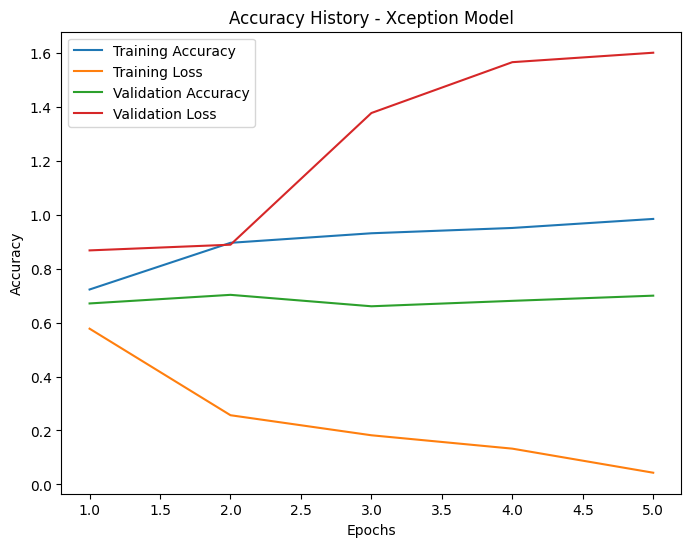

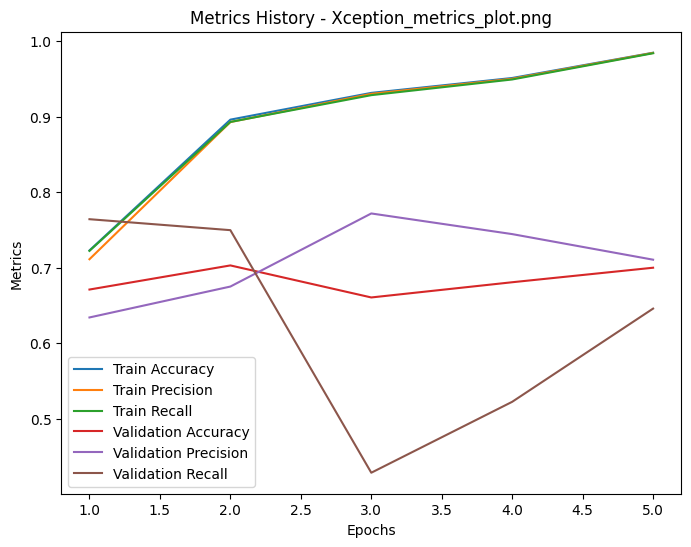

In [48]:
# Experiment ID:TMC-0015 - Xception 
experimentId = "TMC-0015"

# Load Directories (Leave alone unless specifying a different dataset)
experiment_train_directory = "/media/luke/System Storage/Deepfake Dataset/FF++/combine/train"
experiment_test_directory = "/media/luke/System Storage/Deepfake Dataset/FF++/combine/test"
experiment_directory = f"{experiment_base_directory}/{experimentId}"
experiment_results_directory = f"{experiment_directory}/results"
experiment_models_directory = f"{experiment_directory}/models"

# Create directories if they don't exist
os.makedirs(name=experiment_directory, exist_ok=True)
os.makedirs(name=experiment_models_directory, exist_ok=True)
os.makedirs(name=experiment_results_directory, exist_ok=True)

# Declare lists for report generation
accuracy_report = []

# Declare Test Configurations
test_configurations = [
    [Xception, xception_preprocess_input]
]

# Define Early Stopping Callback
# Define callbacks
early_stopping = EarlyStopping(
    monitor='val_loss', 
    mode='min', 
    verbose=1, 
    patience=4
)

lr_reducer = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.25,
    patience=3,
    verbose=1,
)

model_checkpoint_accuracy = ModelCheckpoint(
    filepath=f"{experiment_models_directory}/model_highest_accuracy.h5",
    monitor="val_binary_accuracy",
    save_best_only=True,
    verbose=1, 
)

model_checkpoint_loss = ModelCheckpoint(
    filepath=f"{experiment_models_directory}/model_lowest_loss.h5",
    monitor="val_loss",
    save_best_only=True,
    verbose=1, 
)

callbacks = [early_stopping, lr_reducer, model_checkpoint_accuracy, model_checkpoint_loss]

# Loop through all combinations of models and trainable layers
for pretrained_model, preprocessing_function in test_configurations:
    K.clear_session()
    
    # Create a dataset and preprocess images to suit base model
    train_ds = create_train_dataset(preprocessing_function, experiment_train_directory, batch_size=64, augment_data=False)
    test_ds = create_test_dataset(preprocessing_function, experiment_test_directory, batch_size=64)

    # Create Input Layer
    inputs = Input(shape=(299, 299, 3))

    # Create the base model from the pre-trained model
    base_model = pretrained_model(
        weights="imagenet", 
        include_top=False,
        input_tensor=inputs)

    # Make Base Model Trainable
    base_model.trainable = False
    
    # Freeze the base model (do not train everything but last 23 layers)
    for layer in base_model.layers[:-23]:
        layer.trainable = False
    
    # Add a classification head
    top_model = base_model(inputs, training=False)
    top_model = Conv2D(1024, (3, 3), padding='same')(top_model)
    top_model = BatchNormalization()(top_model)
    top_model = Activation('relu')(top_model)
    top_model = MaxPooling2D(pool_size=(2, 2))(top_model)

    top_model = Conv2D(1024, (3, 3), padding='same')(top_model)
    top_model = BatchNormalization()(top_model)
    top_model = Activation('relu')(top_model)
    top_model = MaxPooling2D(pool_size=(2, 2))(top_model)

    top_model = GlobalAveragePooling2D()(top_model)
    top_model = Dense(1024, activation='relu')(top_model)
    top_model = BatchNormalization()(top_model)
    top_model = Dropout(0.8)(top_model)

    top_model = Dense(1024, activation='relu')(top_model)
    top_model = BatchNormalization()(top_model)
    top_model = Dropout(0.8)(top_model)

    top_model = Dense(1, activation='sigmoid')(top_model)

    model = Model(inputs=base_model.input, outputs=top_model)
    
    # Compile the model
    model.compile(
        optimizer=Adam(1e-2),  
        loss=BinaryCrossentropy(from_logits=False),
        metrics=[BinaryAccuracy(), Precision(), Recall(), AUC()]
    )
    
    # Create Model Image
    create_model_image(model, experiment_models_directory, name = f'{pretrained_model.__name__}_model', extension = 'png')
    
    # Start Timer to measure processing time 
    start_time = time.time()

    # Train the model but first clear history (Required to append results without errors)
    history = model.fit(
        train_ds, 
        steps_per_epoch=train_ds.samples // train_ds.batch_size,
        epochs=20, 
        validation_data=test_ds,
        validation_steps=test_ds.samples // test_ds.batch_size,
        callbacks = callbacks
    )
    
    # End Timer and calculate processing time
    end_time = time.time()
    processing_time = end_time - start_time

    # Evaluate the model
    evaluate = model.evaluate(test_ds, steps = test_ds.samples // test_ds.batch_size, verbose=1)
    
    # Save Model & Weights
    model.save(f"{experiment_models_directory}/final_model.h5")
    model.save_weights(f"{experiment_models_directory}/final_model_weights.h5")
    
    # Append results to accuracy_test list
    history_key = list(history.history.keys()) # As names of metric names can be dynamic, we need to get the keys of the history object
    accuracy_report.append({
        'Base Model': pretrained_model.__name__,
        'duration': round(processing_time, 3),
        'test_accuracy': round(evaluate[1], 3),
        'test_precision': round(evaluate[2], 3),
        'test_recall': round(evaluate[3], 3),
        'test_loss': round(evaluate[0], 3),
        'train_accuracy': round(history.history[history_key[1]][-1],3),
        'train_precision': round(history.history[history_key[2]][-1],3),
        'train_recall': round(history.history[history_key[3]][-1],3),
        'train_auc' : round(history.history[history_key[4]][-1],3),
        'train_loss': round(history.history[history_key[0]][-1],3),
        'val_accuracy': round(history.history[history_key[6]][-1],3),
        'val_precision': round(history.history[history_key[7]][-1],3),
        'val_recall': round(history.history[history_key[8]][-1],3),
        'val_auc' : round(history.history[history_key[9]][-1],3),
        'val_loss': round(history.history[history_key[5]][-1],3)
    })
    
    epochs_report = pd.DataFrame(history.history)
    epochs_report.to_csv(f"{experiment_results_directory}/{pretrained_model.__name__}_epochs_report.csv", index=False)

# Create DataFrame with accuracy score and export as .csv
accuracy_test_results = pd.DataFrame(accuracy_report)
accuracy_test_results.to_csv(f'{experiment_results_directory}/accuracy_test_results.csv', index=False)

# Generate graphs from epochs_reports.csv and output to results folder.
create_accuracy_plots(f"{experiment_results_directory}")
create_all_metrics_plots(f"{experiment_results_directory}")

Found 9660 images belonging to 2 classes.
Found 2414 images belonging to 2 classes.
Found 4279 images belonging to 2 classes.
Epoch 1/50


2023-05-28 23:41:45.717666: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


301/301 [==============================] - ETA: 0s - loss: 0.2003 - binary_accuracy: 0.9176 - precision: 0.9201 - recall: 0.9092 - auc: 0.9755

2023-05-28 23:43:41.342666: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]



Epoch 1: val_binary_accuracy improved from -inf to 0.97042, saving model to ../experiments/top-model-configuration/TMC-0015/FT-1/models/model_highest_accuracy.h5

Epoch 1: val_loss improved from inf to 0.08136, saving model to ../experiments/top-model-configuration/TMC-0015/FT-1/models/model_lowest_loss.h5
301/301 [==============================] - 124s 397ms/step - loss: 0.2003 - binary_accuracy: 0.9176 - precision: 0.9201 - recall: 0.9092 - auc: 0.9755 - val_loss: 0.0814 - val_binary_accuracy: 0.9704 - val_precision: 0.9757 - val_recall: 0.9631 - val_auc: 0.9972 - lr: 1.0000e-06
Epoch 2/50
301/301 [==============================] - ETA: 0s - loss: 0.1957 - binary_accuracy: 0.9201 - precision: 0.9224 - recall: 0.9120 - auc: 0.9766
Epoch 2: val_binary_accuracy did not improve from 0.97042

Epoch 2: val_loss did not improve from 0.08136
301/301 [==============================] - 118s 391ms/step - loss: 0.1957 - binary_accuracy: 0.9201 - precision: 0.9224 - recall: 0.9120 - auc: 0.9766 

2023-05-28 23:59:25.023051: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


133/133 [==============================] - 12s 89ms/step - loss: 0.7919 - binary_accuracy: 0.7303 - precision: 0.7371 - recall: 0.6937 - auc: 0.7981


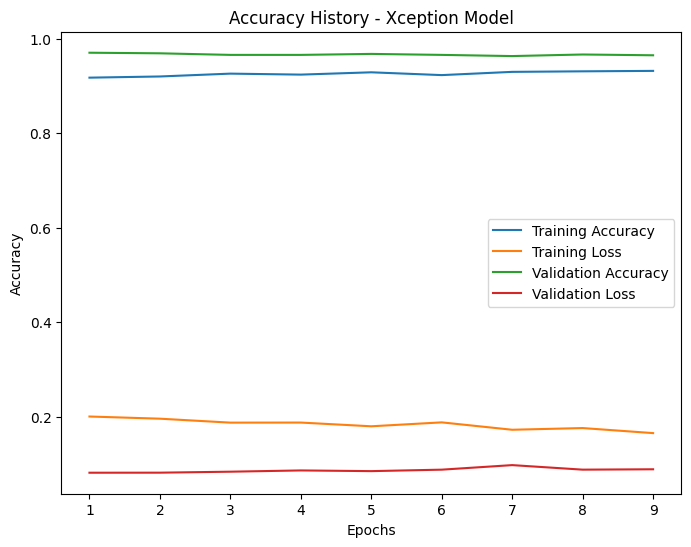

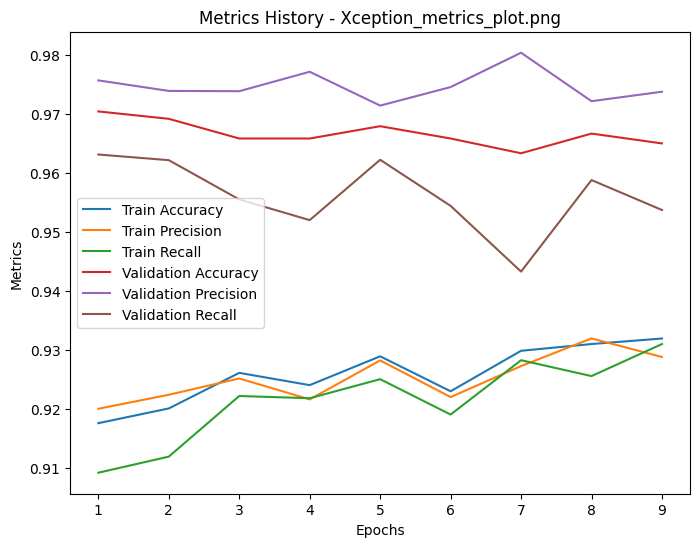

In [49]:
# Experiment ID:TMC-0015 - Xception 
experimentId = "TMC-0015"
finetuneVersion = "FT-1"

# Load Directories (Leave alone unless specifying a different dataset)
experiment_train_directory = train_directory
experiment_test_directory = test_directory
experiment_directory = f"{experiment_base_directory}/{experimentId}/{finetuneVersion}"
experiment_results_directory = f"{experiment_directory}/results"
experiment_models_directory = f"{experiment_directory}/models"

# Create directories if they don't exist
os.makedirs(name=experiment_directory, exist_ok=True)
os.makedirs(name=experiment_models_directory, exist_ok=True)
os.makedirs(name=experiment_results_directory, exist_ok=True)

# Declare lists for report generation
accuracy_report = []

# Declare Test Configurations
test_configurations = [
    [Xception, xception_preprocess_input]
]

# Define Early Stopping Callback
# Define callbacks
early_stopping = EarlyStopping(
    monitor='val_loss', 
    mode='min', 
    verbose=1, 
    patience=8
)

lr_reducer = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.25,
    patience=7,
    verbose=1,
)

model_checkpoint_accuracy = ModelCheckpoint(
    filepath=f"{experiment_models_directory}/model_highest_accuracy.h5",
    monitor="val_binary_accuracy",
    save_best_only=True,
    verbose=1, 
)

model_checkpoint_loss = ModelCheckpoint(
    filepath=f"{experiment_models_directory}/model_lowest_loss.h5",
    monitor="val_loss",
    save_best_only=True,
    verbose=1, 
)

callbacks = [early_stopping, lr_reducer, model_checkpoint_accuracy, model_checkpoint_loss]

# Loop through all combinations of models and trainable layers
for pretrained_model, preprocessing_function in test_configurations:
    K.clear_session()

    # Create a dataset and preprocess images to suit base model
    train_ds, val_ds = create_train_val_datasets(preprocessing_function, experiment_train_directory, batch_size=32, augment_data=True)
    test_ds = create_test_dataset(preprocessing_function, experiment_test_directory, batch_size=32)

    # Load Model
    model = keras.models.load_model(
        "../experiments/top-model-configuration/TMC-0013/models/final_model.h5"
    )
    
    # Create Input Layer
    inputs = Input(shape=(299, 299, 3))

    # Base model is the second layer in the model
    base_model = model.layers[1]

    # Make Base Model Trainable
    base_model.trainable = True

    # Freeze the base model (do not train everything but last 23 layers)
    for layer in base_model.layers[:-23]:
        layer.trainable = False

    # Everything after the base model is your top model
    # We need to hook up these layers correctly to the base model
    inputs = keras.Input(shape=(299, 299, 3))
    x = base_model(inputs, training=False)

    # Traverse the layers and connect them
    for layer in model.layers[2:]:
        x = layer(x)

    # Define the model
    model = keras.Model(inputs=inputs, outputs=x)

    # Compile the model
    model.compile(
        optimizer=Adam(1e-6),  
        loss=BinaryCrossentropy(from_logits=False),
        metrics=[BinaryAccuracy(), Precision(), Recall(), AUC()]
    )

    # Create Model Image
    create_model_image(model, experiment_models_directory, name = f'{pretrained_model.__name__}_model', extension = 'png')

    # Start Timer to measure processing time 
    start_time = time.time()

    # Train the model but first clear history (Required to append results without errors)
    history = model.fit(
        train_ds, 
        steps_per_epoch=train_ds.samples // train_ds.batch_size,
        epochs=50, 
        validation_data=val_ds,
        validation_steps=val_ds.samples // val_ds.batch_size,
        callbacks = callbacks
    )

    # End Timer and calculate processing time
    end_time = time.time()
    processing_time = end_time - start_time

    # Evaluate the model
    evaluate = model.evaluate(test_ds, steps = test_ds.samples // test_ds.batch_size, verbose=1)

    # Append results to accuracy_test list
    history_key = list(history.history.keys()) # As names of metric names can be dynamic, we need to get the keys of the history object
    accuracy_report.append({
        'Base Model': pretrained_model.__name__,
        'duration': round(processing_time, 3),
        'test_accuracy': round(evaluate[1], 3),
        'test_precision': round(evaluate[2], 3),
        'test_recall': round(evaluate[3], 3),
        'test_loss': round(evaluate[0], 3),
        'train_accuracy': round(history.history[history_key[1]][-1],3),
        'train_precision': round(history.history[history_key[2]][-1],3),
        'train_recall': round(history.history[history_key[3]][-1],3),
        'train_auc' : round(history.history[history_key[4]][-1],3),
        'train_loss': round(history.history[history_key[0]][-1],3),
        'val_accuracy': round(history.history[history_key[6]][-1],3),
        'val_precision': round(history.history[history_key[7]][-1],3),
        'val_recall': round(history.history[history_key[8]][-1],3),
        'val_auc' : round(history.history[history_key[9]][-1],3),
        'val_loss': round(history.history[history_key[5]][-1],3)
    })

    epochs_report = pd.DataFrame(history.history)
    epochs_report.to_csv(f"{experiment_results_directory}/{pretrained_model.__name__}_epochs_report.csv", index=False)

    model.save(f"{experiment_models_directory}/final_model_finetunned.h5")
    model.save_weights(f"{experiment_models_directory}/final_model_weights.h5")
    
# Create DataFrame with accuracy score and export as .csv
accuracy_test_results = pd.DataFrame(accuracy_report)
accuracy_test_results.to_csv(f'{experiment_results_directory}/accuracy_test_results.csv', index=False)

# Generate graphs from epochs_reports.csv and output to results folder.
create_accuracy_plots(f"{experiment_results_directory}")
create_all_metrics_plots(f"{experiment_results_directory}")